## **Problem Statement**

### Business Context

A sales forecast is a prediction of future sales revenue based on historical data, industry trends, and the status of the current sales pipeline. Businesses use the sales forecast to estimate weekly, monthly, quarterly, and annual sales totals. A company needs to make an accurate sales forecast as it adds value across an organization and helps the different verticals to chalk out their future course of action.

Forecasting helps an organization plan its sales operations by region and provides valuable insights to the supply chain team regarding the procurement of goods and materials. An accurate sales forecast process has many benefits which include improved decision-making about the future and reduction of sales pipeline and forecast risks. Moreover, it helps to reduce the time spent in planning territory coverage and establish benchmarks that can be used to assess trends in the future.

### Objective

SuperKart is a retail chain operating supermarkets and food marts across various tier cities, offering a wide range of products. To optimize its inventory management and make informed decisions around regional sales strategies, SuperKart wants to accurately forecast the sales revenue of its outlets for the upcoming quarter.

To operationalize these insights at scale, the company has partnered with a data science firm—not just to build a predictive model based on historical sales data, but to develop and deploy a robust forecasting solution that can be integrated into SuperKart’s decision-making systems and used across its network of stores.

### Data Description

The data contains the different attributes of the various products and stores.The detailed data dictionary is given below.

- **Product_Id** - unique identifier of each product, each identifier having two letters at the beginning followed by a number.
- **Product_Weight** - weight of each product
- **Product_Sugar_Content** - sugar content of each product like low sugar, regular and no sugar
- **Product_Allocated_Area** - ratio of the allocated display area of each product to the total display area of all the products in a store
- **Product_Type** - broad category for each product like meat, snack foods, hard drinks, dairy, canned, soft drinks, health and hygiene, baking goods, bread, breakfast, frozen foods, fruits and vegetables, household, seafood, starchy foods, others
- **Product_MRP** - maximum retail price of each product
- **Store_Id** - unique identifier of each store
- **Store_Establishment_Year** - year in which the store was established
- **Store_Size** - size of the store depending on sq. feet like high, medium and low
- **Store_Location_City_Type** - type of city in which the store is located like Tier 1, Tier 2 and Tier 3. Tier 1 consists of cities where the standard of living is comparatively higher than its Tier 2 and Tier 3 counterparts.
- **Store_Type** - type of store depending on the products that are being sold there like Departmental Store, Supermarket Type 1, Supermarket Type 2 and Food Mart
- **Product_Store_Sales_Total** - total revenue generated by the sale of that particular product in that particular store


### 🧠 Reckoning

**ML Task Type**: **Regression** - predicting sales
**Target Variable**: `Product_Store_Sales_Total` - the revenue generated by each product in each store
**Problem Understanding**:
- Predict sales revenue at the **product-store level** (not time series forecasting)
- Features include product characteristics (weight, sugar content, MRP, type, allocated area) and store characteristics (size, location tier, store type, establishment year)
- Cross-sectional prediction problem: given a product and store combination, predict the sales total

**Likely Success Metrics:**
- RMSE/MAE for model performance
- MAPE (Mean Absolute Percentage Error) for business interpretability
- R² for variance explained

> **Key Insight**: Despite the business context mentioning "forecasting for upcoming quarter," the data structure suggests this is a cross-sectional sales prediction problem rather than time series forecasting, since there are no temporal features provided.

**🎯 Objective**

Predict the `Product_Store_Sales_Total` (target variable), enabling:
- Smarter inventory decisions
- Regional strategy optimization
- Integration into production systems (via backend + frontend)

⚠️ **NOTE:**

Despite the term "forecast" being used in the problem statement, the data and setup suggest:
> 🔍 It's a standard regression task, not a time-based forecast.

Here's why: 
- There's no **time** feature (like date, week, month).
- Each row represents a product-store pair, not a time-ordered observation.
- The target (`Product_Store_Sales_Total`) looks like an **aggregate**, not a point in time.

So: 
> ✅ While "forecast" is used for business context,
> technically it's a supervised regression prediction task.

That distinction is important — because it affects:
- Feature choices
- Feature engineering & Model types
- Whether to use time-aware methods (which we don’t need here)

Hence

**Our problem context**: Predict sales for any product-store combination based on meaningful business characteristics.

---

## Import Libraries

In [95]:
# Essential libraries for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import normaltest, shapiro
import tabulate as tb
import pprint as pp

from scipy.stats import skew, zscore

In [96]:
from sklearn.base import BaseEstimator, TransformerMixin
# Data Prep
from sklearn.model_selection import train_test_split

In [14]:
# print pandas version
print(pd.__version__)

2.3.0


In [15]:
import importlib.metadata
# There was some warning for this dependency (from pandas) So just checking and verifying !!
print(importlib.metadata.version("bottleneck"))

1.5.0


In [16]:
# Configure display and plotting
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
plt.style.use('default')
sns.set_palette("husl")
#sns.set_palette('mako')

plt.rcParams["figure.figsize"] = (12, 6)

In [17]:
import warnings
warnings.filterwarnings("ignore")

## Python Utils

In [18]:
def format_pct(val):
    """Format a val as percentage i.e max 2 decimal value & adding % at the end"""
    return f"{val:.2f}%"

def to_pct(value):
    """value is expected to be a normalized float value in [0, 1]"""
    return format_pct(value * 100)

def ratio_to_pct(a, b):
    """
    Convert a ratio to a percentage
    """
    return to_pct(a / b)

In [19]:
def table_it(data, title=None, tablefmt='simple', floatfmt='.2f', orientation='vertical', show_index=False):
    """
    Display single dictionary or pandas Series input as a formatted table

    Parameters:
    -----------
    data : dict or pandas.Series
        The data to display in table format
    title : str, optional
        Optional title for the table
    tablefmt : str, default 'simple'
        Table format style (simple, grid, fancy_grid, etc.)
    floatfmt : str, default '.2f'
        Float formatting for numerical values
    orientation : str, default 'vertical'
        'vertical' for rows, 'horizontal' for columns
    show_index : bool, default False
        Whether to show row numbers/index in the table

    Returns:
    --------
    None - prints formatted table
    """

    if title:
        print(f"\n{title}")
        print("-" * len(title))

    # Handle pandas Series
    if isinstance(data, pd.Series):
        if orientation == 'vertical':
            table_data = data.to_frame()
            print(tb.tabulate(table_data, headers='keys', tablefmt=tablefmt,
                            floatfmt=floatfmt, showindex=show_index))
        else:
            # Horizontal format (with .T)
            table_data = data.to_frame().T
            print(tb.tabulate(table_data, headers='keys', tablefmt=tablefmt,
                            floatfmt=floatfmt, showindex=show_index))

    # Handle dictionary
    elif isinstance(data, dict):
        if orientation == 'vertical':
            if show_index:
                # Add row numbers when show_index=True
                table_data = [[i, key, value] for i, (key, value) in enumerate(data.items(), 1)]
                headers = ['#', 'Key', 'Value']
            else:
                # Standard format without index
                table_data = [[key, value] for key, value in data.items()]
                headers = ['Key', 'Value']
            print(tb.tabulate(table_data, headers=headers, tablefmt=tablefmt, floatfmt=floatfmt))
        else:
            # Horizontal format for dictionary
            keys = list(data.keys())
            values = list(data.values())
            table_data = [values]
            if show_index:
                # For horizontal, we can add index as first row
                index_row = list(range(1, len(keys) + 1))
                table_data.insert(0, index_row)
                headers = ['#'] + keys
            else:
                headers = keys
            print(tb.tabulate(table_data, headers=headers, tablefmt=tablefmt, floatfmt=floatfmt))

    # Handle other iterables (lists, etc.)
    elif hasattr(data, '__iter__') and not isinstance(data, str):
        if show_index:
            # Index is already built-in for this case
            table_data = [[i, value] for i, value in enumerate(data, 1)]
            headers = ['#', 'Value']
        else:
            # Use enumerate starting from 1, but don't show explicit index column
            table_data = [[value] for value in data]
            headers = ['Value']
        print(tb.tabulate(table_data, headers=headers, tablefmt=tablefmt, floatfmt=floatfmt))

    else:
        print(f"Unsupported data type: {type(data)}")
        print("Supported types: pandas.Series, dict, or iterable")

In [20]:
def tb_describe(df_col):
    """
    Helper function to display descriptive statistics in a nicely formatted table

    Parameters:
    df_col : pandas Series or DataFrame column
        The column to generate descriptive statistics for

    Returns:
    None - prints formatted table
    """
    stats = df_col.describe().to_frame().T
    print(tb.tabulate(stats, headers='keys', tablefmt='simple', floatfmt='.2f'))

In [21]:
def classify_column(col: pd.Series) -> str:
    """
    Classify a column into one of the following categories:
    - ID or Unique Identifier
    - Categorical
    - Ordinal or Discrete
    - Continuous Numerical
    - Binary
    - Other / Needs Manual Check
    """
    if col.nunique() == df.shape[0]:
        return "ID or Unique Identifier"
    elif col.dtype == 'object' or col.dtype.name == 'category':
        return "Categorical"
    elif col.dtype in ['int64', 'float64']:
        if col.nunique() < 10:
            return "Ordinal or Discrete (Numerical)"
        else:
            return "Continuous Numerical"
    elif pd.api.types.is_bool_dtype(col):
        return "Binary"
    else:
        return "Other / Needs Manual Check"

## Load the Data

In [22]:
df = pd.read_csv('SuperKart.csv')
# backup of original df
df_original = df.copy()

In [23]:
df.head()

,Product_Id,Product_Weight,Product_Sugar_Content,Product_Allocated_Area,Product_Type,Product_MRP,Store_Id,Store_Establishment_Year,Store_Size,Store_Location_City_Type,Store_Type,Product_Store_Sales_Total
0,FD6114,12.66,Low Sugar,0.027,Frozen Foods,117.08,OUT004,2009,Medium,Tier 2,Supermarket Type2,2842.40
1,FD7839,16.54,Low Sugar,0.144,Dairy,171.43,OUT003,1999,Medium,Tier 1,Departmental Store,4830.02
2,FD5075,14.28,Regular,0.031,Canned,162.08,OUT001,1987,High,Tier 2,Supermarket Type1,4130.16
3,FD8233,12.10,Low Sugar,0.112,Baking Goods,186.31,OUT001,1987,High,Tier 2,Supermarket Type1,4132.18
4,NC1180,9.57,No Sugar,0.010,Health and Hygiene,123.67,OUT002,1998,Small,Tier 3,Food Mart,2279.36


## Data Overview

In [24]:
def overview_data(df):
    """
    Comprehensive data overview function

    Args:
        df: pandas DataFrame

    Returns:
        dict: Overview statistics for further use
    """

    print("🔍 COMPREHENSIVE DATA OVERVIEW")
    print("=" * 50)

    print(f"💾 Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print()

    # 1. Basic Shape & Structure
    r, c = df.shape
    print(f"📊 Dataset Shape: {r:,} rows × {c} columns")
    print(f"🔄 Duplicate Rows: {df.duplicated().sum()}")

    # 2. Missing Values Analysis
    print("\n❓ MISSING VALUES ANALYSIS")
    print("-" * 30)
    missing_count = df.isnull().sum().sum()
    missing_pct = ratio_to_pct(missing_count, len(df))
    missing_data = pd.DataFrame({
        'Column': df.columns,
        'Missing_Count': missing_count,
        'Missing_Percentage': missing_pct
    })
    missing_data = missing_data[missing_data['Missing_Count'] > 0]

    if len(missing_data) == 0:
        print("✅ No missing values found!")
    else:
        print(missing_data.to_string(index=False))

    # 3. Data Types Summary
    print("\n📋 DATA TYPES SUMMARY")
    print("-" * 30)
    dtype_summary = df.dtypes.value_counts()
    for dtype, count in dtype_summary.items():
        print(f"{dtype}: {count} columns")

    # 4. Identify Numerical vs Categorical Columns
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    print(f"\n🔢 NUMERICAL COLUMNS ({len(numerical_cols)}):")
    print(f"   {numerical_cols}")

    print(f"\n🏷️ CATEGORICAL COLUMNS ({len(categorical_cols)}):")
    print(f"   {categorical_cols}")

    # 5. Numerical Columns Statistics
    if numerical_cols:
        print("\n📈 NUMERICAL COLUMNS STATISTICS")
        print("-" * 40)
        numerical_stats = df[numerical_cols].describe().T
        print(numerical_stats.round(2))

    # 6. Categorical Columns Statistics
    if categorical_cols:
        print("\n📊 CATEGORICAL COLUMNS STATISTICS")
        print("-" * 40)
        for col in categorical_cols:
            unique_count = df[col].nunique()
            most_frequent = df[col].mode()[0]
            most_frequent_count = df[col].value_counts().iloc[0]

            print(f"{col}:")
            print(f"  - Unique Values: {unique_count}")
            print(f"  - Most Frequent: '{most_frequent}' ({most_frequent_count:,} times)")
            print(f"  - Sample Values: {list(df[col].unique()[:5])}")
            print()

    # 7. Target Variable Quick Stats (assuming last column or specify)
    target_col = df.columns[-1]  # Assuming target is last column
    if df[target_col].dtype in ['int64', 'float64']:
        print(f"🎯 TARGET VARIABLE: {target_col}")
        print("-" * 30)
        print(f"Min: {df[target_col].min():.2f}")
        print(f"Max: {df[target_col].max():.2f}")
        print(f"Mean: {df[target_col].mean():.2f}")
        print(f"Median: {df[target_col].median():.2f}")
        print(f"Std Dev: {df[target_col].std():.2f}")

    # Return summary for further use
    overview_stats = {
        'shape': df.shape,
        'missing_data': missing_data,
        'numerical_cols': numerical_cols,
        'categorical_cols': categorical_cols,
        'memory_usage_mb': df.memory_usage(deep=True).sum() / 1024**2,
        'duplicates': df.duplicated().sum()
    }

    return overview_stats

In [25]:
# Usage
overview = overview_data(df)

🔍 COMPREHENSIVE DATA OVERVIEW
💾 Memory Usage: 4.16 MB

📊 Dataset Shape: 8,763 rows × 12 columns
🔄 Duplicate Rows: 0

❓ MISSING VALUES ANALYSIS
------------------------------
✅ No missing values found!

📋 DATA TYPES SUMMARY
------------------------------
object: 7 columns
float64: 4 columns
int64: 1 columns

🔢 NUMERICAL COLUMNS (5):
   ['Product_Weight', 'Product_Allocated_Area', 'Product_MRP', 'Store_Establishment_Year', 'Product_Store_Sales_Total']

🏷️ CATEGORICAL COLUMNS (7):
   ['Product_Id', 'Product_Sugar_Content', 'Product_Type', 'Store_Id', 'Store_Size', 'Store_Location_City_Type', 'Store_Type']

📈 NUMERICAL COLUMNS STATISTICS
----------------------------------------
                            count     mean      std     min      25%      50%  \
Product_Weight             8763.0    12.65     2.22     4.0    11.15    12.66   
Product_Allocated_Area     8763.0     0.07     0.05     0.0     0.03     0.06   
Product_MRP                8763.0   147.03    30.69    31.0   126.16   146

In [26]:
print("Columns Summary:")

summary = pd.DataFrame({
    "Column": df.columns,
    "Dtype": df.dtypes.values,
    "Missing": df.isnull().sum().values,
    "Unique": df.nunique().values
})

# Columns Summary
summary

Columns Summary:


,Column,Dtype,Missing,Unique
0,Product_Id,object,0,8763
1,Product_Weight,float64,0,1113
2,Product_Sugar_Content,object,0,4
3,Product_Allocated_Area,float64,0,228
4,Product_Type,object,0,16
5,Product_MRP,float64,0,6100
6,Store_Id,object,0,4
7,Store_Establishment_Year,int64,0,4
8,Store_Size,object,0,3
9,Store_Location_City_Type,object,0,3


🔍 Observation	

- None of the column has missing values
- `Product_Id` and `Store_Id` are nominal identifiers → can be ignored for modeling
- Dataset has mixed types → requires encoding + scaling
> `Store_Establishment_Year` can be treated as categorical though its type is numeric

In [27]:
# Target variable stats summary
print("Target variable distribution:")
df['Product_Store_Sales_Total'].describe()

Target variable distribution:


count    8763.000000
mean     3464.003640
std      1065.630494
min        33.000000
25%      2761.715000
50%      3452.340000
75%      4145.165000
max      8000.000000
Name: Product_Store_Sales_Total, dtype: float64

**🎯 TARGET VARIABLE INSIGHTS:**

1. **Sales range**: $33 - $8,000 shows diverse performance across stores
2. **Normal distribution**: Mean ≈ Median indicates balanced, model-friendly data
3. **Moderate spread**: 31% variation suggests consistent but varied performance

In [28]:
# ===========================
# 2. FEATURE CATEGORIZATION
# ===========================

# Define feature categories for systematic analysis
NUMERICAL_FEATURES = [
    'Product_Weight',
    'Product_Allocated_Area',
    'Product_MRP',
    'Store_Establishment_Year'
]

CATEGORICAL_FEATURES = [
    'Product_Sugar_Content',
    'Product_Type',
    'Store_Size',
    'Store_Location_City_Type',
    'Store_Type'
]

TARGET_VARIABLE = 'Product_Store_Sales_Total'

print("🏷️ FEATURE CATEGORIZATION")
print("-" * 40)
print(f"Numerical Features ({len(NUMERICAL_FEATURES)}): {NUMERICAL_FEATURES}")
print(f"Categorical Features ({len(CATEGORICAL_FEATURES)}): {CATEGORICAL_FEATURES}")
print(f"Target Variable: {TARGET_VARIABLE}")

🏷️ FEATURE CATEGORIZATION
----------------------------------------
Numerical Features (4): ['Product_Weight', 'Product_Allocated_Area', 'Product_MRP', 'Store_Establishment_Year']
Categorical Features (5): ['Product_Sugar_Content', 'Product_Type', 'Store_Size', 'Store_Location_City_Type', 'Store_Type']
Target Variable: Product_Store_Sales_Total


## EDA

### Univariate Analysis

#### Helper (Utils)

In [29]:
class UnivariateAnalyzer:
    """
    Comprehensive univariate analysis for EDA and preprocessing guidance

    Methods:
    - analyze_numerical_column: Complete numerical feature analysis
    - analyze_categorical_column: Complete categorical feature analysis
    """

    def __init__(self, figsize=(12, 6)):
        """
        Initialize analyzer with plotting configuration

        Args:
            figsize: Figure size for plots (default: (12, 6))
        """
        self.figsize = figsize
        # plt.style.use('default')

    def analyze_numerical_column(self, df, column_name):
        """
        Comprehensive analysis for a single numerical column

        Args:
            df: pandas DataFrame
            column_name: string, name of the numerical column

        Returns:
            dict: Analysis results for preprocessing guidance
        """

        print(f"📊 NUMERICAL ANALYSIS: {column_name}")
        print("=" * 50)

        col_data = df[column_name].dropna()

        # 1. Basic Statistics
        print("📈 DESCRIPTIVE STATISTICS")
        print("-" * 30)
        desc_stats = col_data.describe()
        print(desc_stats.round(3))

        # 2. Distribution Analysis
        print("\n📋 DISTRIBUTION ANALYSIS")
        print("-" * 30)

        # Skewness & Kurtosis
        skewness = stats.skew(col_data)
        kurtosis = stats.kurtosis(col_data)

        print(f"Skewness: {skewness:.3f}")
        if abs(skewness) < 0.5:
            skew_interpretation = "Approximately Normal"
        elif abs(skewness) < 1:
            skew_interpretation = "Moderately Skewed"
        else:
            skew_interpretation = "Highly Skewed"
        print(f"Interpretation: {skew_interpretation}")

        print(f"Kurtosis: {kurtosis:.3f}")
        if abs(kurtosis) < 3:
            kurt_interpretation = "Normal-like tails"
        else:
            kurt_interpretation = "Heavy tails"
        print(f"Interpretation: {kurt_interpretation}")

        # 3. Outlier Detection
        print("\n🔍 OUTLIER ANALYSIS")
        print("-" * 30)

        Q1 = col_data.quantile(0.25)
        Q3 = col_data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = col_data[(col_data < lower_bound) | (col_data > upper_bound)]
        outlier_percentage = (len(outliers) / len(col_data)) * 100

        print("IQR Method:")
        print(f"  Lower Bound: {lower_bound:.3f}")
        print(f"  Upper Bound: {upper_bound:.3f}")
        print(f"  Outliers: {len(outliers)} ({outlier_percentage:.1f}%)")

        # 4. Missing Values
        missing_count = df[column_name].isnull().sum()
        missing_percentage = (missing_count / len(df)) * 100
        print("\n❓ MISSING VALUES")
        print("-" * 30)
        print(f"Count: {missing_count} ({missing_percentage:.1f}%)")

        # 5. Preprocessing Recommendations
        print("\n🔧 PREPROCESSING RECOMMENDATIONS")
        print("-" * 30)

        recommendations = []

        # Scaling recommendations
        if col_data.std() > 1000 or col_data.max() - col_data.min() > 1000:
            recommendations.append("Consider StandardScaler or MinMaxScaler (large scale)")

        # Transformation recommendations
        if skewness > 1:
            recommendations.append("Consider Log transformation (right skewed)")
        elif skewness < -1:
            recommendations.append("Consider Square transformation (left skewed)")

        # Outlier handling
        if outlier_percentage > 5:
            recommendations.append("Consider RobustScaler (many outliers)")
        elif outlier_percentage > 1:
            recommendations.append("Consider outlier treatment (moderate outliers)")

        # Missing value handling
        if missing_percentage > 0:
            if missing_percentage < 5:
                recommendations.append("Consider mean/median imputation")
            else:
                recommendations.append("Investigate missing pattern, consider advanced imputation")

        if not recommendations:
            recommendations.append("Data appears clean, minimal preprocessing needed")

        for i, rec in enumerate(recommendations, 1):
            print(f"{i}. {rec}")

        # 6. Visualization
        fig, axes = plt.subplots(1, 2, figsize=self.figsize)
        fig.suptitle(f'{column_name} - Distribution Analysis', fontsize=14, fontweight='bold')

        # Histogram
        axes[0].hist(col_data, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0].axvline(col_data.mean(), color='red', linestyle='--', label=f'Mean: {col_data.mean():.2f}')
        axes[0].axvline(col_data.median(), color='green', linestyle='--', label=f'Median: {col_data.median():.2f}')
        axes[0].set_title('Distribution')
        axes[0].set_xlabel(column_name)
        axes[0].set_ylabel('Frequency')
        axes[0].legend()

        # Boxplot
        axes[1].boxplot(col_data)
        axes[1].set_title('Boxplot (Outlier Detection)')
        axes[1].set_ylabel(column_name)

        plt.tight_layout()
        plt.show()

        # Return analysis results
        analysis_results = {
            'skewness': skewness,
            'kurtosis': kurtosis,
            'outlier_percentage': outlier_percentage,
            'missing_percentage': missing_percentage,
            'recommendations': recommendations,
            'statistics': desc_stats.to_dict()
        }

        return analysis_results

    def analyze_categorical_column(self, df, column_name):
        """
        Comprehensive analysis for a single categorical column

        Args:
            df: pandas DataFrame
            column_name: string, name of the categorical column

        Returns:
            dict: Analysis results for preprocessing guidance
        """

        print(f"📊 CATEGORICAL ANALYSIS: {column_name}")
        print("=" * 50)

        col_data = df[column_name]

        # 1. Basic Statistics
        print("📈 DESCRIPTIVE STATISTICS")
        print("-" * 30)

        unique_count = col_data.nunique()
        total_count = len(col_data)

        print(f"Total Values: {total_count:,}")
        print(f"Unique Values: {unique_count}")
        print(f"Cardinality: {'High' if unique_count > 10 else 'Medium' if unique_count > 2 else 'Low'}")

        # 2. Value Distribution
        print("\n📋 VALUE DISTRIBUTION")
        print("-" * 30)

        value_counts = col_data.value_counts()
        value_percentages = col_data.value_counts(normalize=True) * 100

        print("Top 10 Values:")
        for i, (value, count) in enumerate(value_counts.head(10).items(), 1):
            percentage = value_percentages[value]
            print(f"{i:2d}. {value}: {count:,} ({percentage:.1f}%)")

        # 3. Data Quality Check
        print("\n🔍 DATA QUALITY CHECK")
        print("-" * 30)

        # Missing values
        missing_count = col_data.isnull().sum()
        missing_percentage = (missing_count / len(col_data)) * 100
        print(f"Missing Values: {missing_count} ({missing_percentage:.1f}%)")

        # Check for inconsistencies (case sensitivity, whitespace, etc.)
        quality_issues = []

        # Case sensitivity check
        values_lower = [str(v).lower() for v in col_data.dropna().unique()]
        if len(values_lower) != len(set(values_lower)):
            quality_issues.append("Potential case sensitivity issues")

        # Whitespace check
        string_values = [str(v) for v in col_data.dropna().unique()]
        stripped_values = [v.strip() for v in string_values]
        if len(string_values) != len(set(stripped_values)):
            quality_issues.append("Potential whitespace issues")

        # Check for abbreviated vs full forms
        if any(len(str(v)) <= 3 for v in col_data.dropna().unique()):
            quality_issues.append("Mix of abbreviated and full forms detected")

        if quality_issues:
            print("Issues Found:")
            for issue in quality_issues:
                print(f"  ⚠️  {issue}")
        else:
            print("✅ No major quality issues detected")

        # 4. Class Imbalance Analysis
        print("\n⚖️  CLASS BALANCE ANALYSIS")
        print("-" * 30)

        # Check for imbalance
        min_percentage = value_percentages.min()
        max_percentage = value_percentages.max()
        imbalance_ratio = max_percentage / min_percentage

        print(f"Most Common: {max_percentage:.1f}%")
        print(f"Least Common: {min_percentage:.1f}%")
        print(f"Imbalance Ratio: {imbalance_ratio:.1f}:1")

        if imbalance_ratio > 10:
            balance_status = "Highly Imbalanced"
        elif imbalance_ratio > 5:
            balance_status = "Moderately Imbalanced"
        else:
            balance_status = "Reasonably Balanced"

        print(f"Status: {balance_status}")

        # 5. Preprocessing Recommendations
        print("\n🔧 PREPROCESSING RECOMMENDATIONS")
        print("-" * 30)

        recommendations = []

        # Encoding recommendations
        if unique_count == 2:
            recommendations.append("Consider Label Encoding (binary categorical)")
        elif unique_count <= 5:
            recommendations.append("Consider One-Hot Encoding (low cardinality)")
        else:
            recommendations.append("Consider Target Encoding or Embedding (high cardinality)")

        # Quality improvements
        if quality_issues:
            recommendations.append("Clean data inconsistencies before encoding")

        # Handle missing values
        if missing_percentage > 0:
            if missing_percentage < 5:
                recommendations.append("Consider mode imputation for missing values")
            else:
                recommendations.append("Investigate missing pattern, consider 'Unknown' category")

        # Handle imbalance
        if imbalance_ratio > 10:
            recommendations.append("(Imbalance) Consider grouping rare categories or stratified sampling")

        for i, rec in enumerate(recommendations, 1):
            print(f"{i}. {rec}")

        # 6. Visualization
        plt.figure(figsize=self.figsize)

        # Limit to top 15 categories for readability
        top_categories = value_counts.head(15)

        # Create bar plot
        bars = plt.bar(range(len(top_categories)), top_categories.values,
                      color=plt.cm.Set3(np.linspace(0, 1, len(top_categories))))

        plt.title(f'{column_name} - Value Distribution (Top 15)', fontsize=14, fontweight='bold')
        plt.xlabel('Categories')
        plt.ylabel('Count')
        plt.xticks(range(len(top_categories)), top_categories.index, rotation=45, ha='right')

        # Add value labels on bars
        for bar, count in zip(bars, top_categories.values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(top_categories.values)*0.01,
                    f'{count:,}', ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.show()

        # Return analysis results
        analysis_results = {
            'unique_count': unique_count,
            'missing_percentage': missing_percentage,
            'imbalance_ratio': imbalance_ratio,
            'quality_issues': quality_issues,
            'recommendations': recommendations,
            'value_counts': value_counts.to_dict()
        }

        return analysis_results

In [30]:
analyzer = UnivariateAnalyzer()

#### 0. Product ID 

> Since this is nominal by nature nothing to explore for it

#### 1. Product Weight

In [31]:
# Nature of column
classify_column(df['Product_Weight'])

'Continuous Numerical'

📊 NUMERICAL ANALYSIS: Product_Weight
📈 DESCRIPTIVE STATISTICS
------------------------------
count    8763.000
mean       12.654
std         2.217
min         4.000
25%        11.150
50%        12.660
75%        14.180
max        22.000
Name: Product_Weight, dtype: float64

📋 DISTRIBUTION ANALYSIS
------------------------------
Skewness: 0.018
Interpretation: Approximately Normal
Kurtosis: 0.004
Interpretation: Normal-like tails

🔍 OUTLIER ANALYSIS
------------------------------
IQR Method:
  Lower Bound: 6.605
  Upper Bound: 18.725
  Outliers: 54 (0.6%)

❓ MISSING VALUES
------------------------------
Count: 0 (0.0%)

🔧 PREPROCESSING RECOMMENDATIONS
------------------------------
1. Data appears clean, minimal preprocessing needed


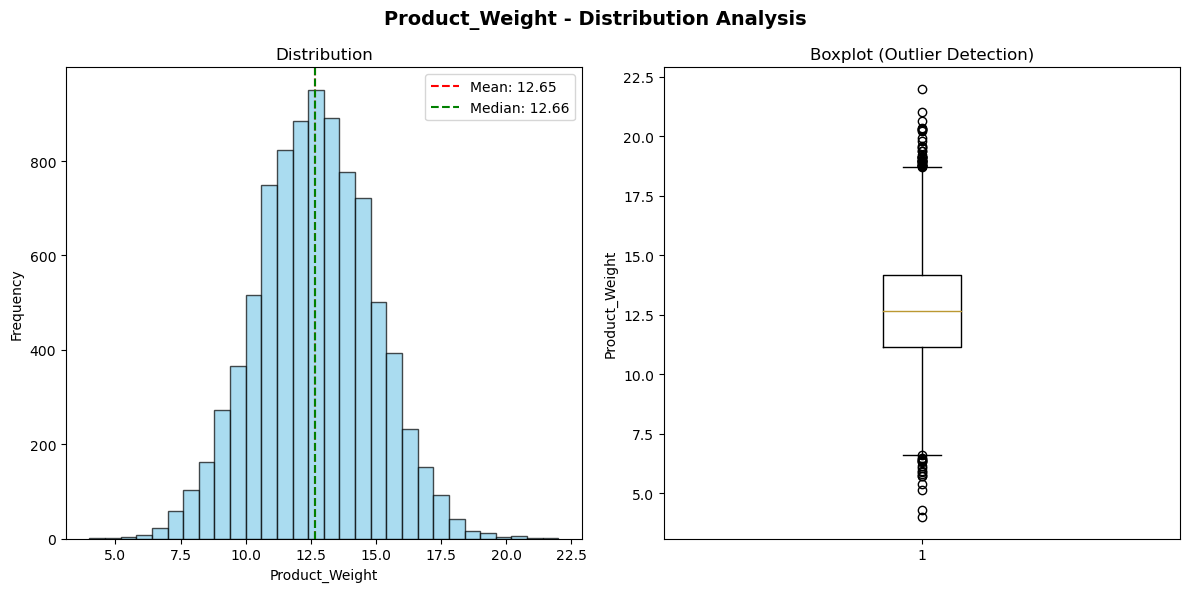

In [32]:
results = analyzer.analyze_numerical_column(df, 'Product_Weight')

In [33]:
pp.pprint(results)

{'kurtosis': 0.003881980226869697,
 'missing_percentage': 0.0,
 'outlier_percentage': 0.6162273194111606,
 'recommendations': ['Data appears clean, minimal preprocessing needed'],
 'skewness': 0.01751117204148118,
 'statistics': {'25%': 11.15,
                '50%': 12.66,
                '75%': 14.18,
                'count': 8763.0,
                'max': 22.0,
                'mean': 12.653792080337787,
                'min': 4.0,
                'std': 2.217320137619363}}


**🔍 Observations:**

• **Nearly perfect distribution**: Skewness (0.02) and mean ≈ median indicate well-balanced, normal-like data distribution

• **High data quality**: Zero missing values and minimal outliers (0.6%) suggest clean, reliable weight measurements across products

• **Preprocessing advantage**: Excellent statistical properties mean minimal transformation needed

> 📌 NOTE: Scaling decision depends on final model choice

**So What To Do with** `Product_Weight` ?

No transformation → it’s already symmetric and clean

✅ But scale it (e.g., StandardScaler) along with other numeric features during preprocessing

#### 2. Product Sugar Content

In [34]:
# Nature of column
classify_column(df['Product_Sugar_Content'])

'Categorical'

📊 CATEGORICAL ANALYSIS: Product_Sugar_Content
📈 DESCRIPTIVE STATISTICS
------------------------------
Total Values: 8,763
Unique Values: 4
Cardinality: Medium

📋 VALUE DISTRIBUTION
------------------------------
Top 10 Values:
 1. Low Sugar: 4,885 (55.7%)
 2. Regular: 2,251 (25.7%)
 3. No Sugar: 1,519 (17.3%)
 4. reg: 108 (1.2%)

🔍 DATA QUALITY CHECK
------------------------------
Missing Values: 0 (0.0%)
Issues Found:
  ⚠️  Mix of abbreviated and full forms detected

⚖️  CLASS BALANCE ANALYSIS
------------------------------
Most Common: 55.7%
Least Common: 1.2%
Imbalance Ratio: 45.2:1
Status: Highly Imbalanced

🔧 PREPROCESSING RECOMMENDATIONS
------------------------------
1. Consider One-Hot Encoding (low cardinality)
2. Clean data inconsistencies before encoding
3. (Imbalance) Consider grouping rare categories or stratified sampling


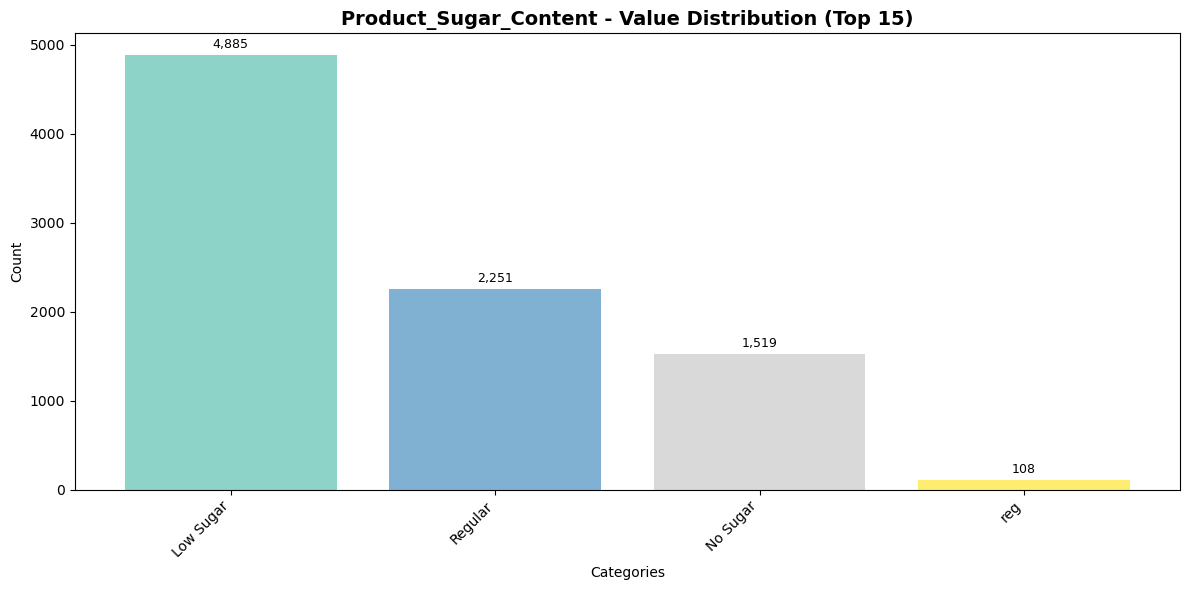

In [35]:
results = analyzer.analyze_categorical_column(df, 'Product_Sugar_Content')

In [36]:
print('Product_Sugar_Content')
pp.pprint(results)

Product_Sugar_Content
{'imbalance_ratio': 45.23148148148148,
 'missing_percentage': 0.0,
 'quality_issues': ['Mix of abbreviated and full forms detected'],
 'recommendations': ['Consider One-Hot Encoding (low cardinality)',
                     'Clean data inconsistencies before encoding',
                     '(Imbalance) Consider grouping rare categories or '
                     'stratified sampling'],
 'unique_count': 4,
 'value_counts': {'Low Sugar': 4885,
                  'No Sugar': 1519,
                  'Regular': 2251,
                  'reg': 108}}


**📌 Observation: `Product_Sugar_Content`**

* Column captures **sugar level** of products with 4 unique categories.
* The data contains both **inconsistent formats** (e.g. `'Regular'` vs `'reg'`) → needs **cleaning** before use.
* Category distribution is **highly imbalanced**, with **'Low Sugar' dominating \~56%** of entries.
* Low cardinality — can be **one-hot encoded** after cleaning.

**Solution Strategy**:
- **NOT sampling** (that's for classification targets)

Instead:
- **Merge rare categories** ('reg' → 'Regular')
- Domain knowledge grouping if makes business sense

#### 3. Product Allocated Area

desc: space given on display for this product amongst all other products from same store

In [37]:
# Nature of column
classify_column(df['Product_Allocated_Area'])

'Continuous Numerical'

In [38]:
df['Product_Allocated_Area'].head()

0    0.027
1    0.144
2    0.031
3    0.112
4    0.010
Name: Product_Allocated_Area, dtype: float64

> NOTE : It's a **ratio**, hence value will always lie between **0 to 1**

📊 NUMERICAL ANALYSIS: Product_Allocated_Area
📈 DESCRIPTIVE STATISTICS
------------------------------
count    8763.000
mean        0.069
std         0.048
min         0.004
25%         0.031
50%         0.056
75%         0.096
max         0.298
Name: Product_Allocated_Area, dtype: float64

📋 DISTRIBUTION ANALYSIS
------------------------------
Skewness: 1.128
Interpretation: Highly Skewed
Kurtosis: 1.292
Interpretation: Normal-like tails

🔍 OUTLIER ANALYSIS
------------------------------
IQR Method:
  Lower Bound: -0.067
  Upper Bound: 0.194
  Outliers: 104 (1.2%)

❓ MISSING VALUES
------------------------------
Count: 0 (0.0%)

🔧 PREPROCESSING RECOMMENDATIONS
------------------------------
1. Consider Log transformation (right skewed)
2. Consider outlier treatment (moderate outliers)


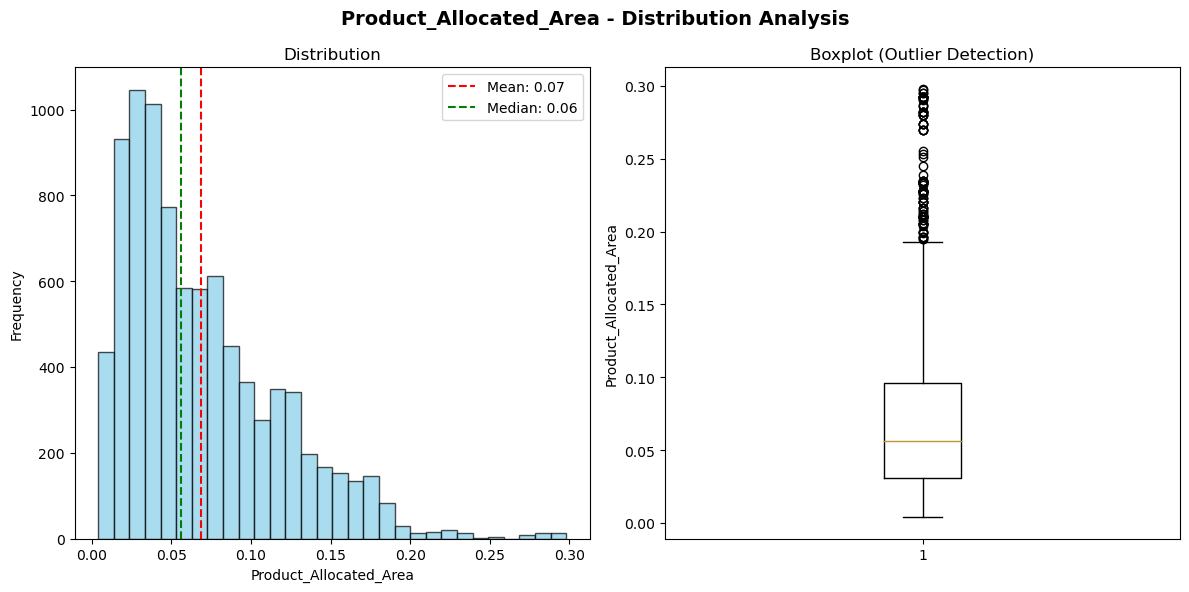

In [39]:
results = analyzer.analyze_numerical_column(df, 'Product_Allocated_Area')

⚡ **Insights**

- There are few outliers (tailing to upper end)

In [40]:
print('Product_Allocated_Area')
pp.pprint(results)

Product_Allocated_Area
{'kurtosis': 1.2917138525421574,
 'missing_percentage': 0.0,
 'outlier_percentage': 1.1868081707177907,
 'recommendations': ['Consider Log transformation (right skewed)',
                     'Consider outlier treatment (moderate outliers)'],
 'skewness': 1.1279000327813162,
 'statistics': {'25%': 0.031,
                '50%': 0.056,
                '75%': 0.096,
                'count': 8763.0,
                'max': 0.298,
                'mean': 0.0687863745292708,
                'min': 0.004,
                'std': 0.04820376849944792}}


**🔍 Observations**

- No missing values in this feature.
- Distribution is right-skewed (skewness ≈ 1.13), ie Most products get small shelf space allocation, but few premium products get significantly more display area
- **Business pattern**: Typical product gets ~5.6% allocation, but outliers suggest strategic high-visibility placements for key products

> ⚠️ **Preprocessing needed**: Right skewness and moderate outliers indicate log transformation will improve model performance

> Given its likely link to product visibility and sales, this feature is expected to be an important predictor.



#### 4. Product Type

In [41]:
# Nature of column
classify_column(df['Product_Type'])

'Categorical'

📊 CATEGORICAL ANALYSIS: Product_Type
📈 DESCRIPTIVE STATISTICS
------------------------------
Total Values: 8,763
Unique Values: 16
Cardinality: High

📋 VALUE DISTRIBUTION
------------------------------
Top 10 Values:
 1. Fruits and Vegetables: 1,249 (14.3%)
 2. Snack Foods: 1,149 (13.1%)
 3. Frozen Foods: 811 (9.3%)
 4. Dairy: 796 (9.1%)
 5. Household: 740 (8.4%)
 6. Baking Goods: 716 (8.2%)
 7. Canned: 677 (7.7%)
 8. Health and Hygiene: 628 (7.2%)
 9. Meat: 618 (7.1%)
10. Soft Drinks: 519 (5.9%)

🔍 DATA QUALITY CHECK
------------------------------
Missing Values: 0 (0.0%)
✅ No major quality issues detected

⚖️  CLASS BALANCE ANALYSIS
------------------------------
Most Common: 14.3%
Least Common: 0.9%
Imbalance Ratio: 16.4:1
Status: Highly Imbalanced

🔧 PREPROCESSING RECOMMENDATIONS
------------------------------
1. Consider Target Encoding or Embedding (high cardinality)
2. (Imbalance) Consider grouping rare categories or stratified sampling


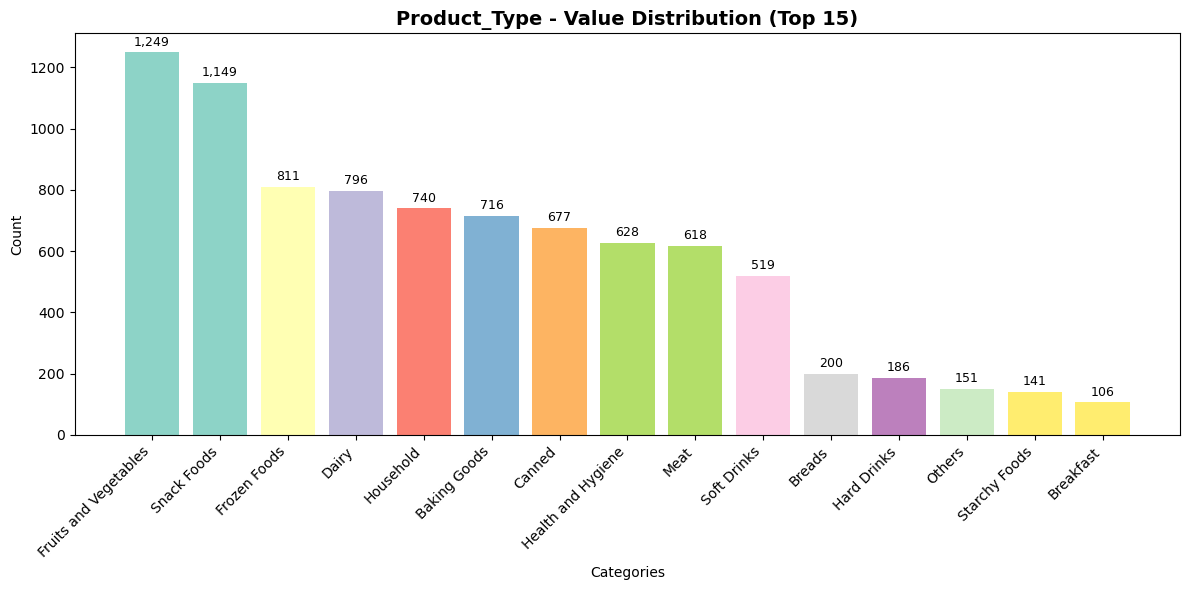

In [42]:
results = analyzer.analyze_categorical_column(df, 'Product_Type')

In [43]:
table_it(results['value_counts'], show_index=True)

  #  Key                      Value
---  ---------------------  -------
  1  Fruits and Vegetables     1249
  2  Snack Foods               1149
  3  Frozen Foods               811
  4  Dairy                      796
  5  Household                  740
  6  Baking Goods               716
  7  Canned                     677
  8  Health and Hygiene         628
  9  Meat                       618
 10  Soft Drinks                519
 11  Breads                     200
 12  Hard Drinks                186
 13  Others                     151
 14  Starchy Foods              141
 15  Breakfast                  106
 16  Seafood                     76


In [44]:
results

{'unique_count': 16,
 'missing_percentage': 0.0,
 'imbalance_ratio': 16.43421052631579,
 'quality_issues': [],
 'recommendations': ['Consider Target Encoding or Embedding (high cardinality)',
  '(Imbalance) Consider grouping rare categories or stratified sampling'],
 'value_counts': {'Fruits and Vegetables': 1249,
  'Snack Foods': 1149,
  'Frozen Foods': 811,
  'Dairy': 796,
  'Household': 740,
  'Baking Goods': 716,
  'Canned': 677,
  'Health and Hygiene': 628,
  'Meat': 618,
  'Soft Drinks': 519,
  'Breads': 200,
  'Hard Drinks': 186,
  'Others': 151,
  'Starchy Foods': 141,
  'Breakfast': 106,
  'Seafood': 76}}

**🔍 Observations `Product_Type`:**

• **Diverse product portfolio**: 16 categories ranging from dominant fresh produce (1,249 items) to niche seafood (76 items) - reflects SuperKart's full supermarket range

• **Clear category hierarchy**: Fresh items (Fruits/Vegetables, Snacks) dominate inventory, while specialty items (Seafood, Breakfast) form smaller segments

• **High cardinality challenge**: 16 categories with 16:1 imbalance ratio requires Target Encoding rather than One-Hot to avoid sparse features

• **Business opportunity**: Rare categories like Seafood might benefit from strategic expansion or could be grouped with similar categories for modeling

> 💡 Group Rare Categories (Valid Option), ie can combine rare product types into an "Other" category. (esp for OHE)

**🧠 NOTE**:
**One-Hot Encoding Problem:**

**Creates 16 binary columns:**
- Fruits_Vegetables: [1,0,0,0,0...] - 1,249 ones, 7,514 zeros
- Snack_Foods: [0,1,0,0,0...] - 1,149 ones, 7,614 zeros  
- Seafood: [0,0,0,0,1...] - Only 76 ones, 8,687 zeros!

**Issues:**
- **Sparse matrix**: Most values are zeros (wasteful)
- **Seafood column**: 99% zeros → barely any signal for model to learn
- **16 features**: Increases dimensionality without much benefit

**Target Encoding Solution:**

**Creates 1 numerical column based on average sales:**
- Fruits_Vegetables → 3,200 (avg sales)
- Snack_Foods → 3,400 (avg sales)
- Seafood → 2,800 (avg sales)
- etc.

**Benefits:**
- **Dense information**: Every value is meaningful
- **1 feature**: Compact representation
- **Handles rare categories**: Even 76 Seafood samples contribute to meaningful average

**Analogy:**

**One-Hot** = Giving each person a separate yes/no checkbox  
**Target** = Giving each person a single "performance score"

**Target Encoding captures the relationship while staying compact!**

**Thumb Rule**

1. **Linear Models**: OHE preferred (avoids false ordinal)
   
2. **Tree Models**: Either works (trees find splits, don't assume order)

- target encoding can mislead linear models into thinking categories have numerical relationships when they don't!
  
So for Product_Type: OHE after grouping rare categories is the safer approach.

> Linear models are associated with OHE because of how they handle coefficients.

- **Each category gets independent treatment** - no forced linear relationships between unrelated categories.
- That's why linear models prefer OHE - it respects the categorical nature of the data.

#### 5 Product MRP

In [45]:
# nature of column
classify_column(df['Product_MRP'])

'Continuous Numerical'

📊 NUMERICAL ANALYSIS: Product_MRP
📈 DESCRIPTIVE STATISTICS
------------------------------
count    8763.000
mean      147.033
std        30.694
min        31.000
25%       126.160
50%       146.740
75%       167.585
max       266.000
Name: Product_MRP, dtype: float64

📋 DISTRIBUTION ANALYSIS
------------------------------
Skewness: 0.037
Interpretation: Approximately Normal
Kurtosis: -0.012
Interpretation: Normal-like tails

🔍 OUTLIER ANALYSIS
------------------------------
IQR Method:
  Lower Bound: 64.022
  Upper Bound: 229.723
  Outliers: 57 (0.7%)

❓ MISSING VALUES
------------------------------
Count: 0 (0.0%)

🔧 PREPROCESSING RECOMMENDATIONS
------------------------------
1. Data appears clean, minimal preprocessing needed


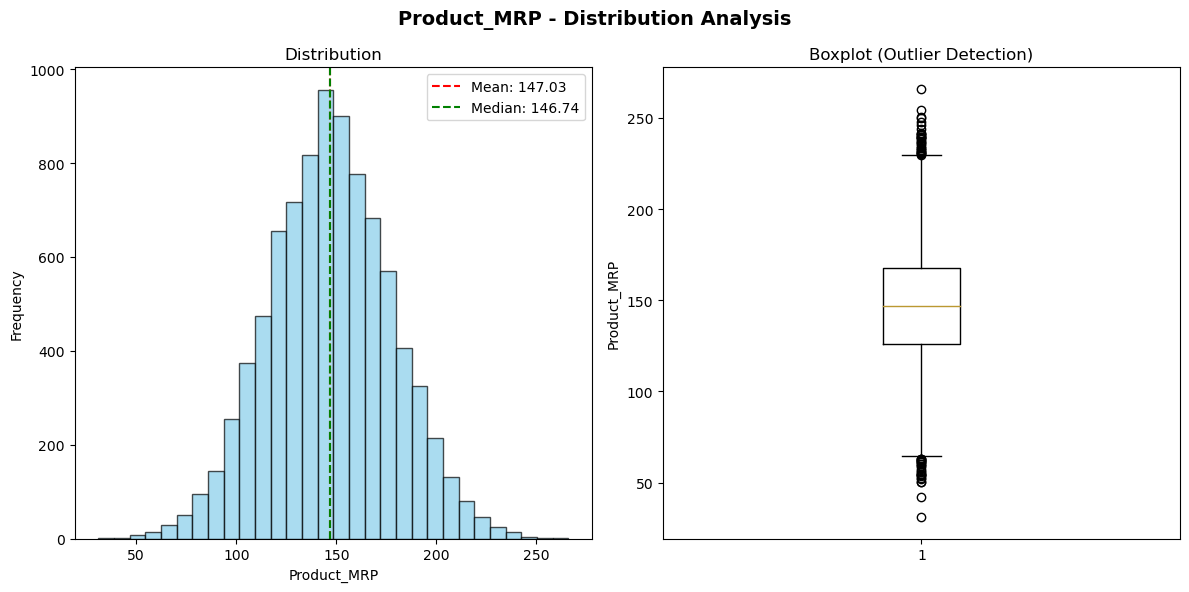

In [46]:
results = analyzer.analyze_numerical_column(df, 'Product_MRP')

In [47]:
pp.pprint(results)

{'kurtosis': -0.01226820030102882,
 'missing_percentage': 0.0,
 'outlier_percentage': 0.6504621704895585,
 'recommendations': ['Data appears clean, minimal preprocessing needed'],
 'skewness': 0.03650675645590474,
 'statistics': {'25%': 126.16,
                '50%': 146.74,
                '75%': 167.585,
                'count': 8763.0,
                'max': 266.0,
                'mean': 147.03253908478834,
                'min': 31.0,
                'std': 30.694110311749952}}


⚡ **Insights**

- Graph seems normally distributed

- The distribution is fairly symmetric (low skewness) and normal-like, indicating good spread across price ranges.

- **Excellent data quality**: No missing values and minimal outliers (0.65%) suggest consistent, reliable pricing data collection

- **Business insight**: Price range (₹31-₹266) with ₹147 average reflects diverse product portfolio from budget to premium segments

- **Preprocessing advantage**: Clean statistical properties require minimal transformation - can use raw MRP values directly in modeling



> 💡 **NOTE:**
> ✅ So, even clean numeric features like this should be scaled (e.g., StandardScaler) when using linear models


#### 6. Store ID 

In [48]:
# nature of column
classify_column(df['Store_Id'])

'Categorical'

📊 CATEGORICAL ANALYSIS: Store_Id
📈 DESCRIPTIVE STATISTICS
------------------------------
Total Values: 8,763
Unique Values: 4
Cardinality: Medium

📋 VALUE DISTRIBUTION
------------------------------
Top 10 Values:
 1. OUT004: 4,676 (53.4%)
 2. OUT001: 1,586 (18.1%)
 3. OUT003: 1,349 (15.4%)
 4. OUT002: 1,152 (13.1%)

🔍 DATA QUALITY CHECK
------------------------------
Missing Values: 0 (0.0%)
✅ No major quality issues detected

⚖️  CLASS BALANCE ANALYSIS
------------------------------
Most Common: 53.4%
Least Common: 13.1%
Imbalance Ratio: 4.1:1
Status: Reasonably Balanced

🔧 PREPROCESSING RECOMMENDATIONS
------------------------------
1. Consider One-Hot Encoding (low cardinality)


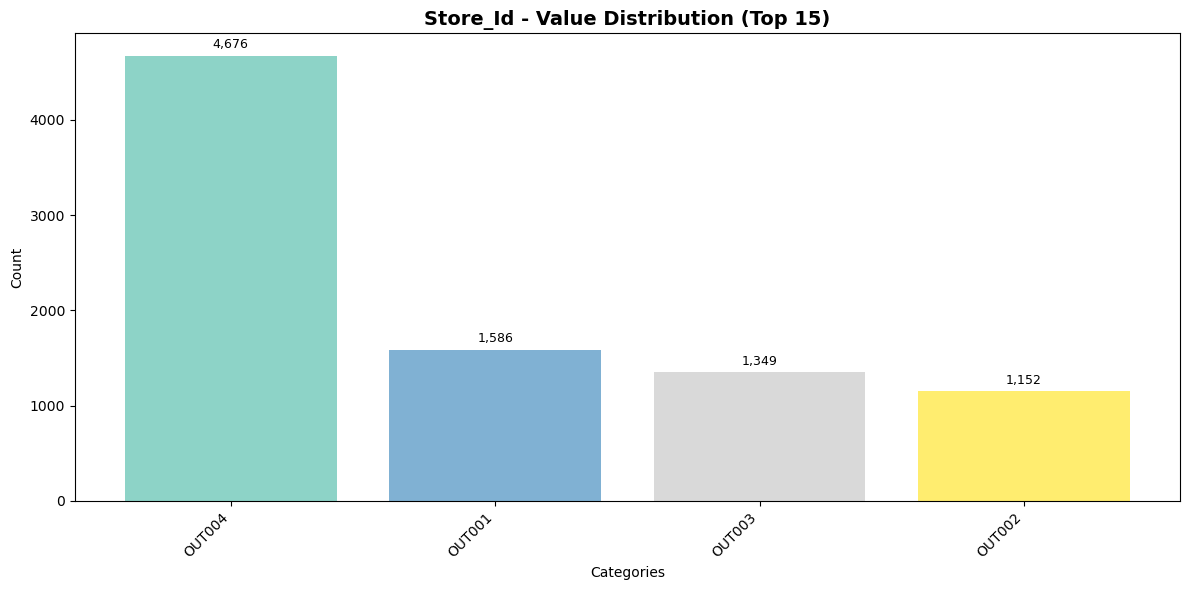

{'unique_count': 4,
 'missing_percentage': 0.0,
 'imbalance_ratio': 4.059027777777777,
 'quality_issues': [],
 'recommendations': ['Consider One-Hot Encoding (low cardinality)'],
 'value_counts': {'OUT004': 4676,
  'OUT001': 1586,
  'OUT003': 1349,
  'OUT002': 1152}}

In [49]:
analyzer.analyze_categorical_column(df, 'Store_Id')

⚡ **Insights**

- Store_Id is a nominal identifier - it doesn't carry inherent predictive value.

- Including it would cause the model to memorize store specific patterns, which hurts generalization to unseen data or stores.

- In real-world deployment, we can't rely on store specific IDs to predict - we want the model to learn from store attributes like type, size, and location.

🔍 **Observations**

- **Uneven store representation**: OUT004 dominates dataset (53% of records) while OUT002 has least data (13%) - reflects different store sizes or product ranges

- **Moderate imbalance**: 4:1 ratio suggests some stores contribute significantly more product-store combinations than others.

- **EDA insight**: Store representation differences may reflect business reality (flagship vs smaller outlets) rather than data collection bias

> ✅ Drop Store_Id - it adds noise and risks overfitting

#### 7. Store Establishment Year

In [50]:
# nature of column
classify_column(df['Store_Establishment_Year'])

'Ordinal or Discrete (Numerical)'

📊 CATEGORICAL ANALYSIS: Store_Establishment_Year
📈 DESCRIPTIVE STATISTICS
------------------------------
Total Values: 8,763
Unique Values: 4
Cardinality: Medium

📋 VALUE DISTRIBUTION
------------------------------
Top 10 Values:
 1. 2009: 4,676 (53.4%)
 2. 1987: 1,586 (18.1%)
 3. 1999: 1,349 (15.4%)
 4. 1998: 1,152 (13.1%)

🔍 DATA QUALITY CHECK
------------------------------
Missing Values: 0 (0.0%)
✅ No major quality issues detected

⚖️  CLASS BALANCE ANALYSIS
------------------------------
Most Common: 53.4%
Least Common: 13.1%
Imbalance Ratio: 4.1:1
Status: Reasonably Balanced

🔧 PREPROCESSING RECOMMENDATIONS
------------------------------
1. Consider One-Hot Encoding (low cardinality)


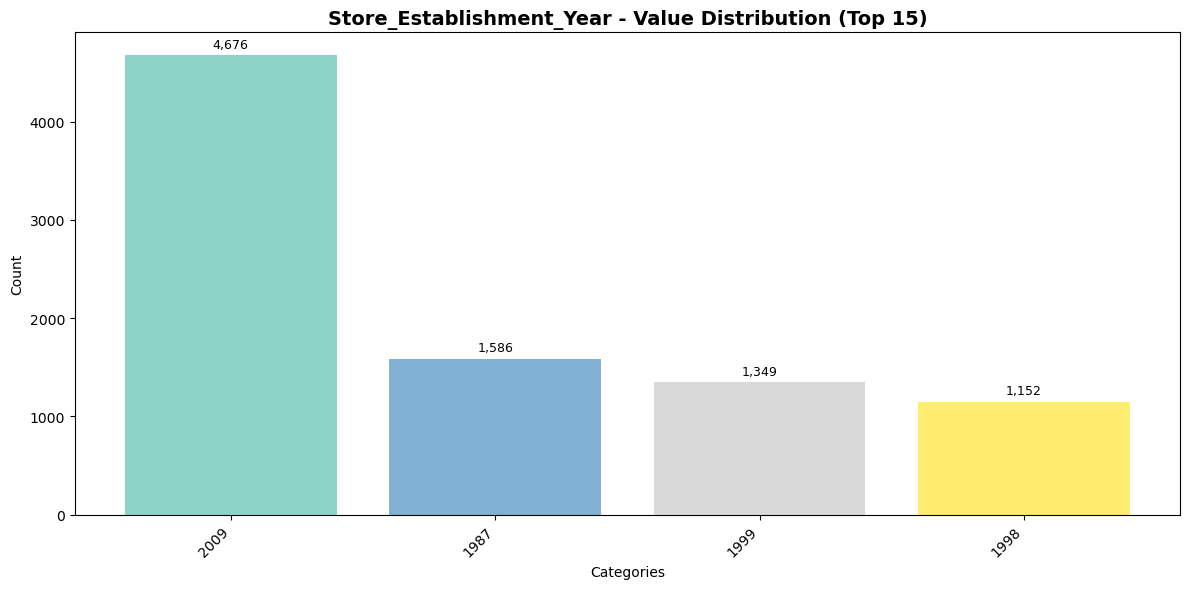

In [51]:
results = analyzer.analyze_categorical_column(df, 'Store_Establishment_Year')

⚡ **Insights**

- As we can see there are only 4 distinct values (although its numeric in nature)
- Also, having so few unique values means it may behave like a quasi-categorical column anyway, and offer limited numeric variance.

Considering as numeric column -

- In regression (especially linear), it assumes linear relationships - e.g., newer stores have proportionally more or less sales - which may or may not be valid.

📌 Risk: It introduces a false sense of continuity or ordering if the relationship is not actually linear.



🧠 **Domain KnowHow**

**Business Context Consideration:**

What really matters for sales ?
- Store Age (maturity, customer loyalty, infrastructure condition)
- Not the specific year it was established

**Recommended Approach: (Feat Eng)**

- **Transform to Store_Age** (ie derived feature)
- Few age buckets: 
  - Bin it into categories
  - e.g. "New" (0-5 years), "Mature" (6-15 years), "Established" (15+ years) → Categorical
- Continuous age: Treat as numeric if linear relationship makes sense

**Store_Age transformation captures the business logic better than raw establishment year.**

#### 8. Store Size

In [52]:
# nature of column
classify_column(df['Store_Size'])

'Categorical'

📊 CATEGORICAL ANALYSIS: Store_Size
📈 DESCRIPTIVE STATISTICS
------------------------------
Total Values: 8,763
Unique Values: 3
Cardinality: Medium

📋 VALUE DISTRIBUTION
------------------------------
Top 10 Values:
 1. Medium: 6,025 (68.8%)
 2. High: 1,586 (18.1%)
 3. Small: 1,152 (13.1%)

🔍 DATA QUALITY CHECK
------------------------------
Missing Values: 0 (0.0%)
✅ No major quality issues detected

⚖️  CLASS BALANCE ANALYSIS
------------------------------
Most Common: 68.8%
Least Common: 13.1%
Imbalance Ratio: 5.2:1
Status: Moderately Imbalanced

🔧 PREPROCESSING RECOMMENDATIONS
------------------------------
1. Consider One-Hot Encoding (low cardinality)


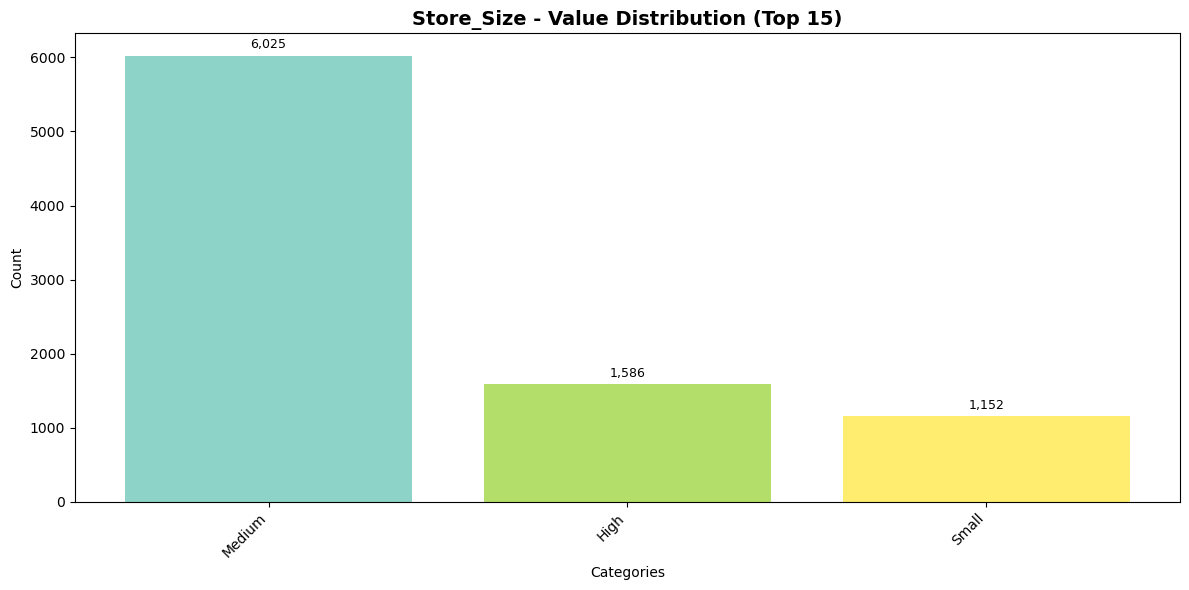

In [53]:
results = analyzer.analyze_categorical_column(df, 'Store_Size')

In [54]:
pp.pprint(results)

{'imbalance_ratio': 5.230034722222221,
 'missing_percentage': 0.0,
 'quality_issues': [],
 'recommendations': ['Consider One-Hot Encoding (low cardinality)'],
 'unique_count': 3,
 'value_counts': {'High': 1586, 'Medium': 6025, 'Small': 1152}}


⚡ **Insights**

- **Medium stores dominate**: 69% of product-store combinations come from medium-sized stores, suggesting SuperKart's primary business model focuses on mid-tier outlets

- **Balanced representation**: All three size categories have substantial data (1,000+ records each) ensuring reliable statistical analysis for each store type. 

- **Natural ordering present**: Small < Medium < High represents clear business hierarchy that should be preserved in modeling

> Prefer Ordinal Encoding for this column !

#### 9. Store Location City Type

In [55]:
# nature of column
classify_column(df['Store_Location_City_Type'])

'Categorical'

📊 CATEGORICAL ANALYSIS: Store_Location_City_Type
📈 DESCRIPTIVE STATISTICS
------------------------------
Total Values: 8,763
Unique Values: 3
Cardinality: Medium

📋 VALUE DISTRIBUTION
------------------------------
Top 10 Values:
 1. Tier 2: 6,262 (71.5%)
 2. Tier 1: 1,349 (15.4%)
 3. Tier 3: 1,152 (13.1%)

🔍 DATA QUALITY CHECK
------------------------------
Missing Values: 0 (0.0%)
✅ No major quality issues detected

⚖️  CLASS BALANCE ANALYSIS
------------------------------
Most Common: 71.5%
Least Common: 13.1%
Imbalance Ratio: 5.4:1
Status: Moderately Imbalanced

🔧 PREPROCESSING RECOMMENDATIONS
------------------------------
1. Consider One-Hot Encoding (low cardinality)


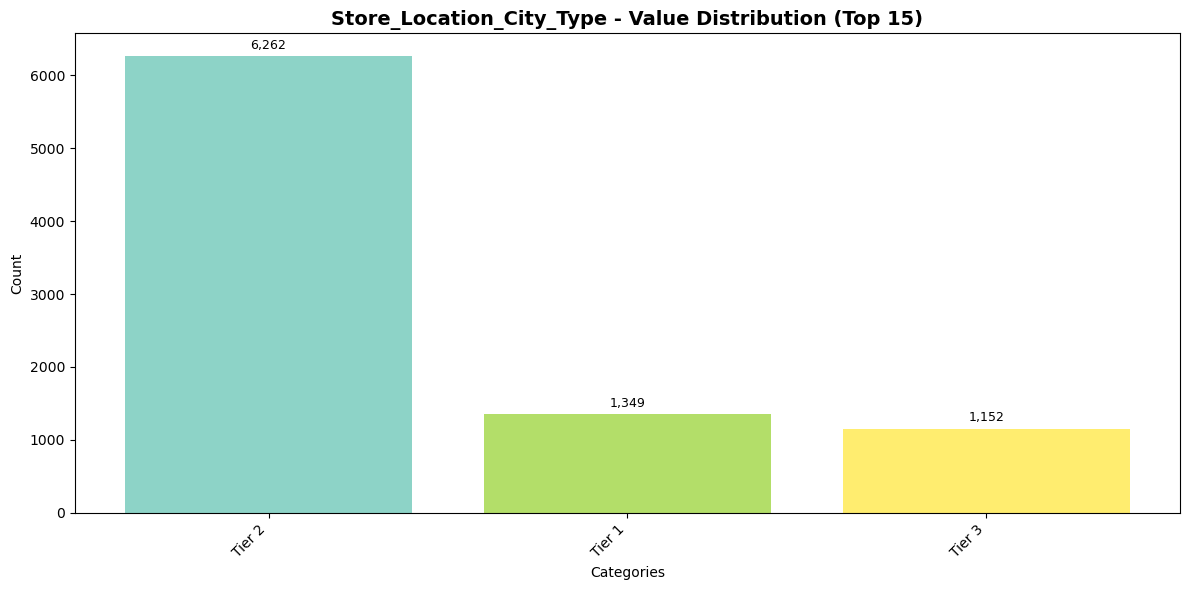

In [56]:
results = analyzer.analyze_categorical_column(df, 'Store_Location_City_Type')

In [57]:
results

{'unique_count': 3,
 'missing_percentage': 0.0,
 'imbalance_ratio': 5.4357638888888875,
 'quality_issues': [],
 'recommendations': ['Consider One-Hot Encoding (low cardinality)'],
 'value_counts': {'Tier 2': 6262, 'Tier 1': 1349, 'Tier 3': 1152}}

⚡ **Insights**

- **Tier 2 city focus**: 71% of SuperKart's operations concentrate in Tier 2 cities, indicating strategic positioning in mid-tier urban markets

- **Balanced tier representation**: Both Tier 1 and Tier 3 cities have similar presence (15% and 13% respectively), suggesting comprehensive market coverage

- Natural city hierarchy: Tier 1 > Tier 2 > Tier 3 represents clear economic progression that should be preserved in modeling

- **Strategic insight**: Heavy Tier 2 presence suggests SuperKart targets growing urban centers rather than just premium or budget markets

> Prefer Ordinal encoding for this column !

#### 10. Store Type

In [58]:
# nature
classify_column(df['Store_Type'])

'Categorical'

📊 CATEGORICAL ANALYSIS: Store_Type
📈 DESCRIPTIVE STATISTICS
------------------------------
Total Values: 8,763
Unique Values: 4
Cardinality: Medium

📋 VALUE DISTRIBUTION
------------------------------
Top 10 Values:
 1. Supermarket Type2: 4,676 (53.4%)
 2. Supermarket Type1: 1,586 (18.1%)
 3. Departmental Store: 1,349 (15.4%)
 4. Food Mart: 1,152 (13.1%)

🔍 DATA QUALITY CHECK
------------------------------
Missing Values: 0 (0.0%)
✅ No major quality issues detected

⚖️  CLASS BALANCE ANALYSIS
------------------------------
Most Common: 53.4%
Least Common: 13.1%
Imbalance Ratio: 4.1:1
Status: Reasonably Balanced

🔧 PREPROCESSING RECOMMENDATIONS
------------------------------
1. Consider One-Hot Encoding (low cardinality)


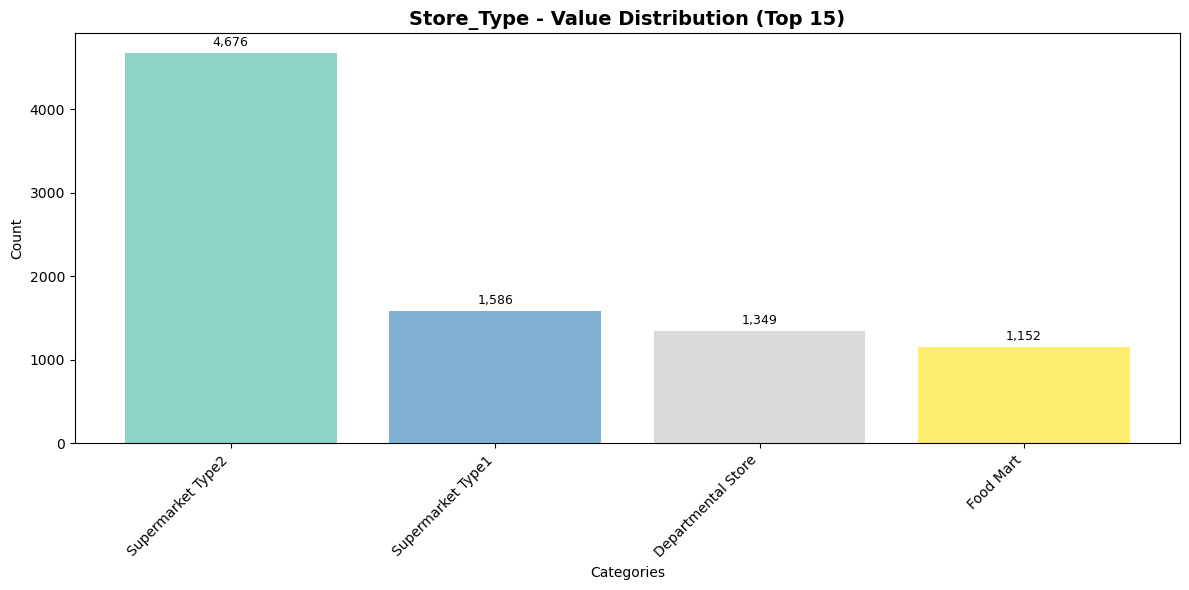

In [59]:
results = analyzer.analyze_categorical_column(df, 'Store_Type')

In [60]:
pp.pprint(results)

{'imbalance_ratio': 4.059027777777777,
 'missing_percentage': 0.0,
 'quality_issues': [],
 'recommendations': ['Consider One-Hot Encoding (low cardinality)'],
 'unique_count': 4,
 'value_counts': {'Departmental Store': 1349,
                  'Food Mart': 1152,
                  'Supermarket Type1': 1586,
                  'Supermarket Type2': 4676}}


⚡ **Insights**

- This is a categorical (nominal) variable with 4 unique types.

- **Supermarket Type2 dominance**: 53% of operations are Type2 format, indicating this is SuperKart's primary business model across locations

- Other formats still have 1000+ samples, ensuring reliable analysis at-least.

> One-Hot Encoding is suitable here 

---

### BiVariate/MultiVariate Analysis

#### **helpers (python)**

In [61]:
class EDAHelper:
    """
    Helper class for common EDA visualizations
    """

    @staticmethod
    def plot_scatter_with_trend(df, x_col_name, y_col_name, x_label, y_label, title=None, color='skyblue', show_it=False):
        """
        Create scatter plot with trend line

        Args:
            df: DataFrame
            x_col_name: x-axis column name
            y_col_name: y-axis column name
            x_label: x-axis label
            y_label: y-axis label
            title: plot title (optional)
            figsize: figure size tuple
            color: scatter plot color
            show_it: whether to show the plot

        Returns:
            correlation coefficient
        """

        x_col = df[x_col_name]
        y_col = df[y_col_name]

        # Scatter plot
        plt.scatter(x_col, y_col, alpha=0.6, color=color)

        # Trend line
        z = np.polyfit(x_col, y_col, 1)
        p = np.poly1d(z)
        plt.plot(x_col, p(x_col), "r--", alpha=0.8)

        # Labels and formatting
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title or f'{x_label} vs {y_label}')
        plt.grid(True, alpha=0.3)

        # Correlation
        correlation = x_col.corr(y_col)
        plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}',
                transform=plt.gca().transAxes, bbox=dict(boxstyle="round", facecolor='white'))

        if show_it:
            plt.tight_layout()
            plt.show()

        return correlation

    @staticmethod
    def plot_binned_analysis(df, x_col_name, y_col_name, x_label, y_label, bins=5, labels=None, title=None, color='lightcoral', show_it=False):
        """
        Create binned analysis bar plot

        Args:
            df: DataFrame
            x_col_name: x-axis column name
            y_col_name: y-axis column name
            x_label: x-axis label
            y_label: y-axis label
            bins: number of bins or custom bin edges
            labels: custom labels for bins
            title: plot title
            figsize: figure size
            color: bar color
            show_it: whether to show the plot

        Returns:
            binned summary series
        """

        # plt.figure(figsize=figsize)
        x_col = df[x_col_name]

        # Create bins
        if labels is None:
            labels = [f'Bin_{i+1}' for i in range(bins)]

        feat_bins = pd.cut(x_col, bins=bins, labels=labels)
        binned_summary = df.groupby(feat_bins)[y_col_name].mean()

        # Bar plot
        bars = plt.bar(binned_summary.index, binned_summary.values, color=color)
        plt.xlabel(x_label + ' Categories')
        plt.ylabel(f'Average {y_label}')
        plt.title(title or f'Average {y_label} by {x_label} Bins')
        plt.xticks(rotation=45)

        # Add value labels on bars
        for bar, value in zip(bars, binned_summary.values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(binned_summary.values)*0.01,
                    f'{value:.0f}', ha='center', va='bottom')
        if show_it:
            plt.tight_layout()
            plt.show()

        return binned_summary

In [62]:
eda_helper = EDAHelper()

**Target Relationship Analysis**

#### 1. MRP vs Sales

🔭 Possible outcome

- Price-sales elasticity, premium vs budget performance

In [63]:
# Product_MRP vs Sales
def analyze_mrp_vs_sales(df):
    """
    Analyze the relationship between Product MRP and Total Sales.

    Plots:
        1. Scatter plot with trend line.
        2. Bar plot of average sales per MRP bin.

    Returns:
        float: Correlation coefficient.
        pd.Series: Average sales per MRP bin.
    """
    # plt.figure(figsize=(12, 6))

    mrp_col = "Product_MRP"
    sales_col = "Product_Store_Sales_Total"

    x_label = "MRP"
    y_label = "Sales"

    # Scatter plot with trend line
    plt.subplot(1, 2, 1)
    correlation = eda_helper.plot_scatter_with_trend(
        df, mrp_col, sales_col, x_label, y_label
    )

    # Binned analysis
    plt.subplot(1, 2, 2)
    binned_summary = eda_helper.plot_binned_analysis(
        df,
        mrp_col,
        sales_col,
        x_label,
        y_label,
        bins=5,
        labels=["Very Low", "Low", "Medium", "High", "Very High"],
    )

    plt.tight_layout()
    plt.show()

    return correlation, binned_summary


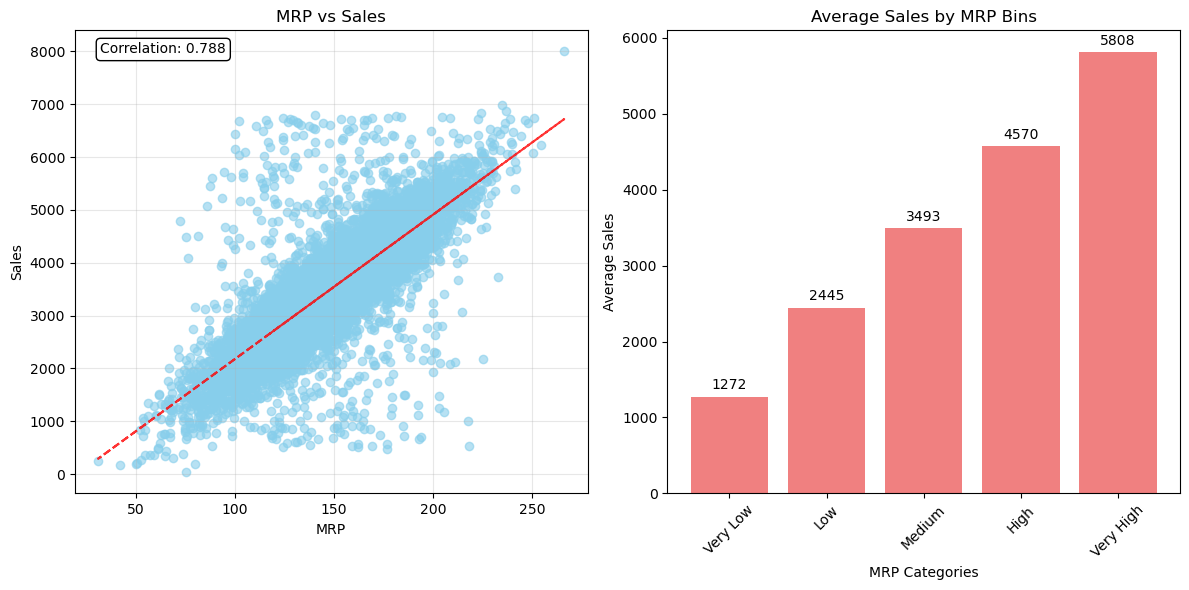

Correlation coefficient: 0.788

Average Sales by MRP Range:
Product_MRP
Very Low     1272.0
Low          2445.0
Medium       3493.0
High         4570.0
Very High    5808.0
Name: Product_Store_Sales_Total, dtype: float64


In [64]:
# Run analysis
correlation, mrp_summary = analyze_mrp_vs_sales(df)
print(f"Correlation coefficient: {correlation:.3f}")
print("\nAverage Sales by MRP Range:")
print(mrp_summary.round(0))

⚡ **Insights**

- **Strong positive relationship**: Correlation of 0.788 indicates higher-priced products consistently generate more sales revenue

- **Clear pricing hierarchy**: Sales nearly quintuple from very low (₹1,272) to very high (₹5,808) MRP ranges, suggesting effective premium pricing strategy

- **Linear trend confirmed**: Consistent step-up across all price categories validates MRP as a strong predictor for sales forecasting

- **Business insight**: SuperKart's pricing strategy aligns well with market demand - premium products deliver proportionally higher returns

#### 2. Product Allocation Area vs Sales

🔭 Possible outcome
- Shelf space ROI, optimal allocation insights

In [65]:
# Product_Allocated_Area vs Sales
def analyze_area_vs_sales(df):
    """
    Analyze relationship between Product Allocated Area and Sales
    """
    x_col_name = "Product_Allocated_Area"
    y_col_name = "Product_Store_Sales_Total"
    x_label = "Allocated Area"
    y_label = "Sales"

    # Correlation coefficient
    plt.subplot(1, 2, 1)
    correlation = eda_helper.plot_scatter_with_trend(
        df, x_col_name, y_col_name, x_label, y_label
    )

    # Binned analysis
    plt.subplot(1, 2, 2)
    binned_summary = eda_helper.plot_binned_analysis(
        df,
        x_col_name,
        y_col_name,
        x_label,
        y_label,
        bins=5,
        labels=["Very Small", "Small", "Medium", "Large", "Very Large"],
    )

    plt.tight_layout()
    plt.show()

    return correlation, binned_summary


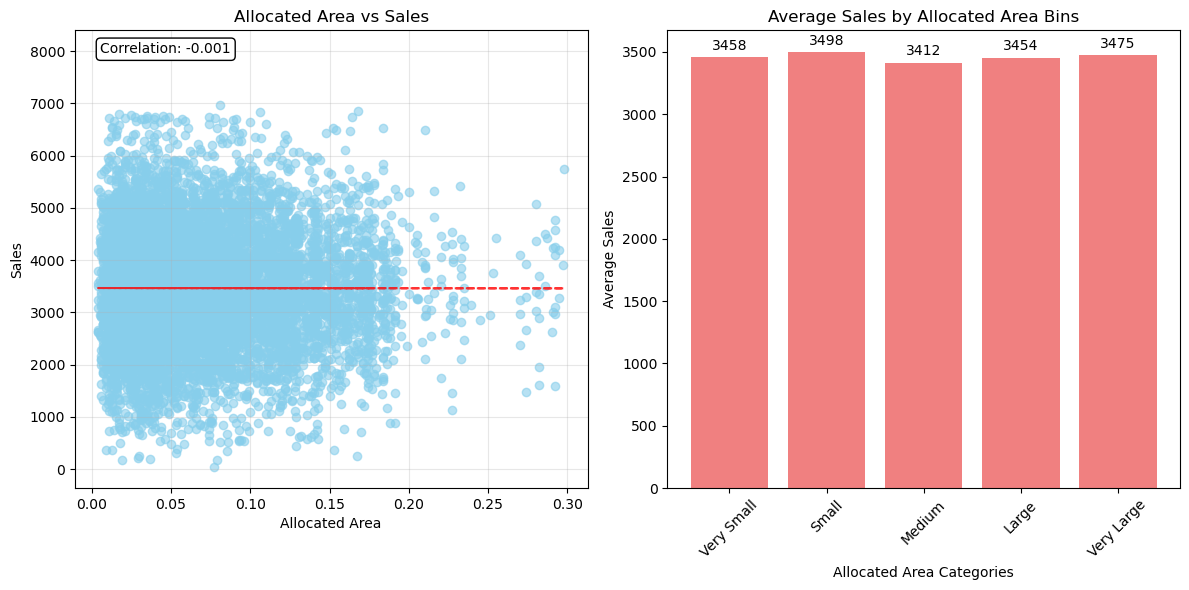

In [66]:
# Run analysis
correlation, area_summary = analyze_area_vs_sales(df)

In [67]:
print(f"Correlation coefficient: {correlation:.3f}")
print("\nAverage Sales by MRP Range:")
print(area_summary.round(0))

Correlation coefficient: -0.001

Average Sales by MRP Range:
Product_Allocated_Area
Very Small    3458.0
Small         3498.0
Medium        3412.0
Large         3454.0
Very Large    3475.0
Name: Product_Store_Sales_Total, dtype: float64


⚡ **Insights**

- **No relationship found**: Near-zero correlation (-0.001) indicates shelf space allocation doesn't drive sales performance

- All allocation categories show similar sales (₹3,412-₹3,498), suggesting current allocation strategy is already optimized

- **Contradicts retail assumptions**: Unlike typical retail wisdom, more display area doesn't translate to higher sales at SuperKart

> Product_Allocated_Area may be less predictive than expected

#### 3 Product Type vs Sales

🔭 Possible outcome
- Category performance ranking
- (validates grouping decisions, as a part of Feature Engineering)

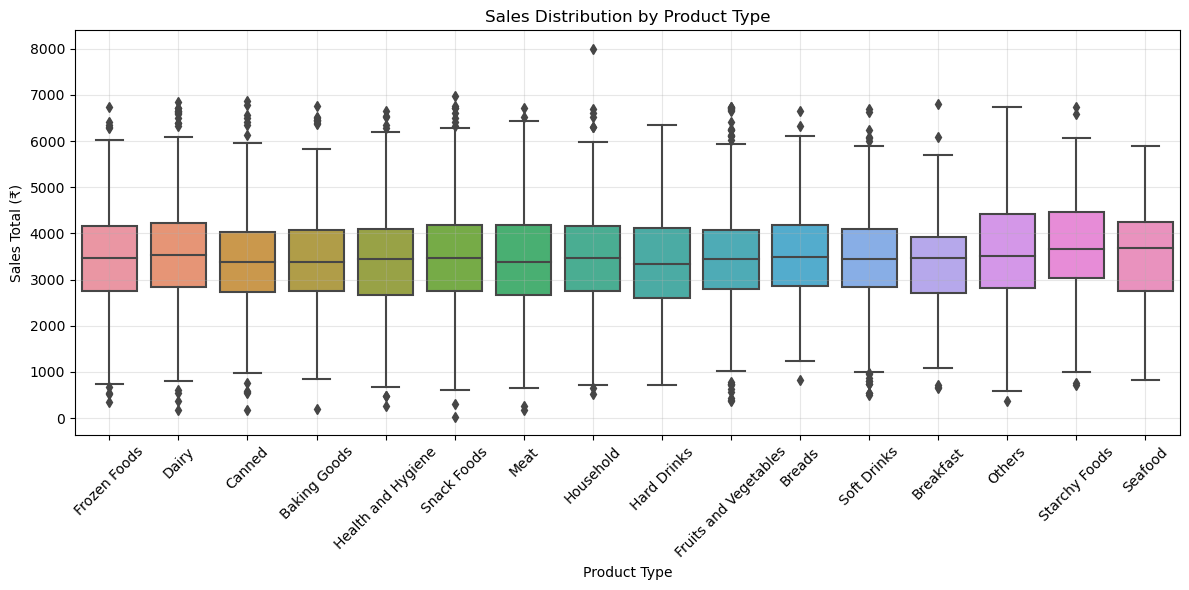

In [68]:
sns.boxplot(data=df, x='Product_Type', y='Product_Store_Sales_Total')
plt.xticks(rotation=45)
plt.title('Sales Distribution by Product Type')
plt.xlabel('Product Type')
plt.ylabel('Sales Total (₹)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

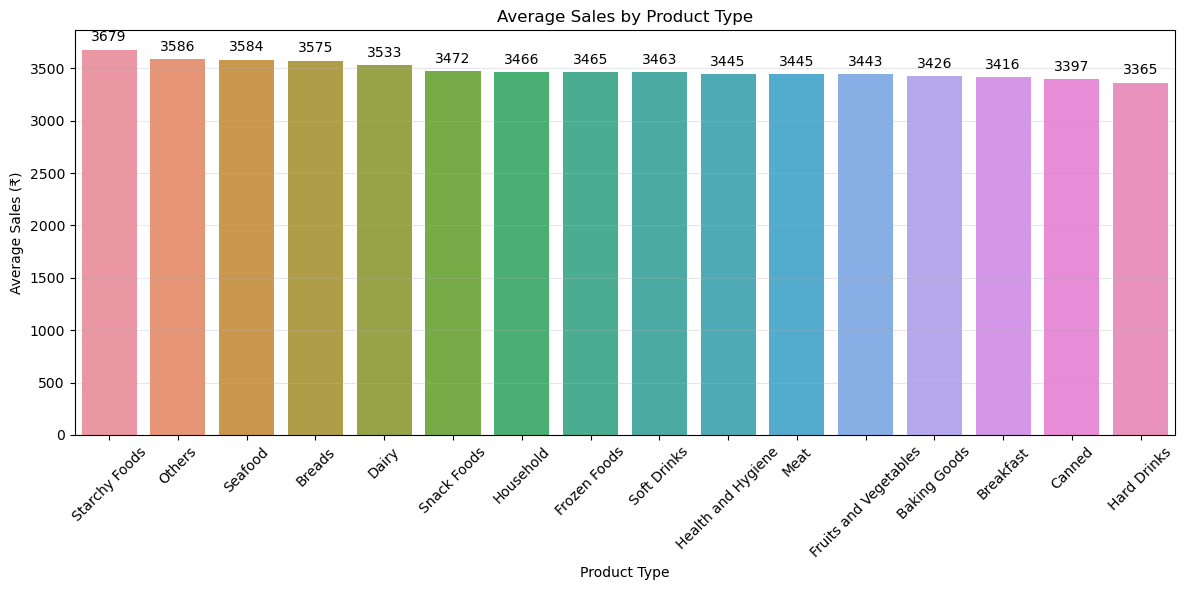

In [69]:
avg_sales = df.groupby('Product_Type')['Product_Store_Sales_Total'].mean().sort_values(ascending=False)

sns.barplot(x=avg_sales.index, y=avg_sales.values)
plt.xticks(rotation=45)
plt.title('Average Sales by Product Type')
plt.xlabel('Product Type')
plt.ylabel('Average Sales (₹)')

# Add value labels
for index, value in enumerate(avg_sales.values):
    plt.text(index, value + 50, f'{value:.0f}', ha='center', va='bottom')

plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [70]:
avg_sales

Product_Type
Starchy Foods            3679.251418
Others                   3586.068212
Seafood                  3584.263684
Breads                   3574.711200
Dairy                    3532.560352
Snack Foods              3471.711880
Household                3465.865095
Frozen Foods             3464.834562
Soft Drinks              3462.513911
Health and Hygiene       3445.393646
Meat                     3445.326764
Fruits and Vegetables    3443.421353
Baking Goods             3425.958101
Breakfast                3416.324623
Canned                   3397.463383
Hard Drinks              3364.594731
Name: Product_Store_Sales_Total, dtype: float64

⚡ **Insights**

- **Narrow performance range**: All categories perform within ₹315 range (₹3,365-₹3,679), indicating product type has modest impact on sales compared to MRP

- **Staple foods lead**: Top performers (Starchy Foods, Others, Seafood, Breads, Dairy) suggest essential/cooking ingredients drive higher sales

- **Beverages underperform**: Hard Drinks rank lowest while Soft Drinks are mid-tier, indicating different consumption patterns across drink categories  

> **Grouping validation**: 🤔 Small performance differences between many categories statistically support combining rare categories during preprocessing

#### 4. Store Size vs Sales

🔭 Possible outcome
- Size-sales relationship, scale benefits

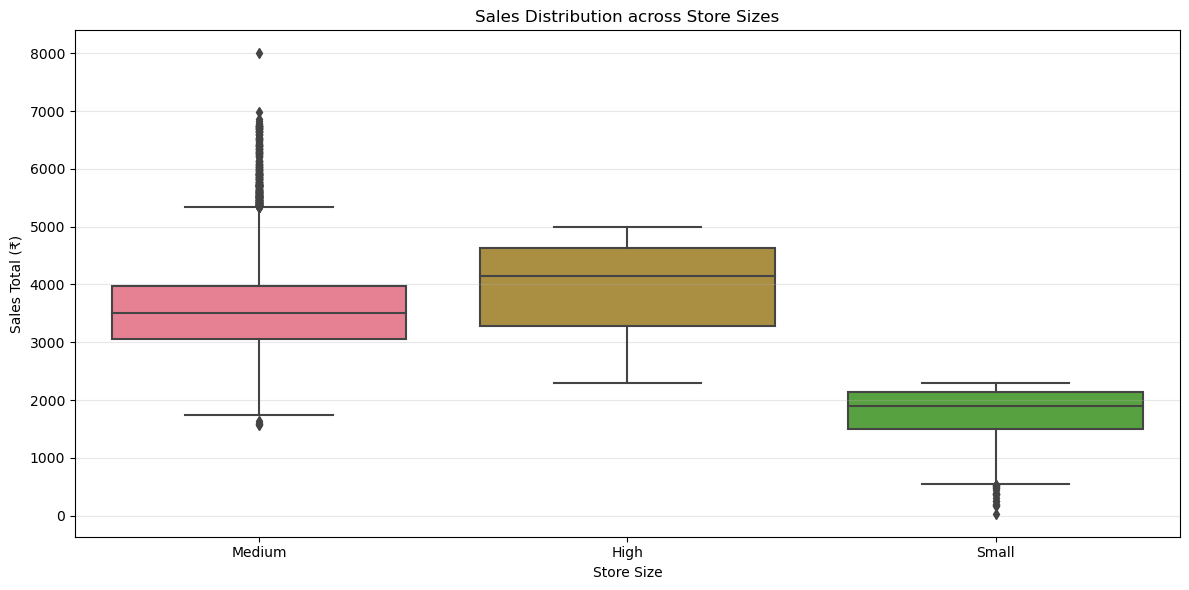

In [71]:
# Box Plot
sns.boxplot(data=df, x='Store_Size', y='Product_Store_Sales_Total')
plt.title('Sales Distribution across Store Sizes')
plt.xlabel('Store Size')
plt.ylabel('Sales Total (₹)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

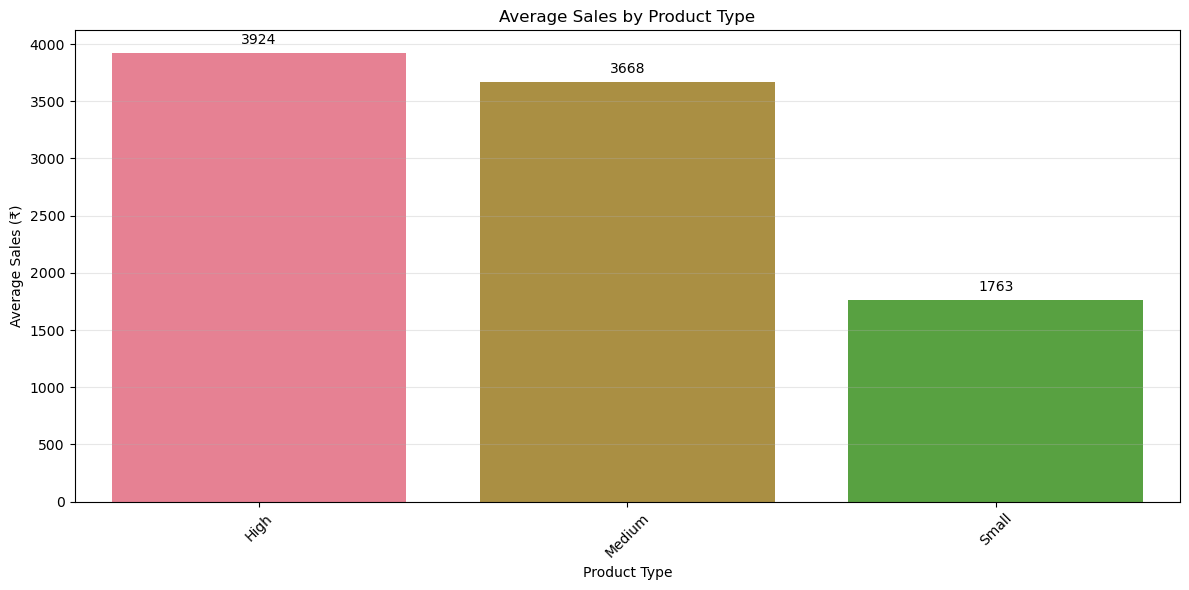

In [72]:
avg_sales = df.groupby('Store_Size')['Product_Store_Sales_Total'].mean().sort_values(ascending=False)

sns.barplot(x=avg_sales.index, y=avg_sales.values)
plt.xticks(rotation=45)
plt.title('Average Sales by Product Type')
plt.xlabel('Product Type')
plt.ylabel('Average Sales (₹)')

# Add value labels
for index, value in enumerate(avg_sales.values):
    plt.text(index, value + 50, f'{value:.0f}', ha='center', va='bottom')

plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [73]:
avg_sales

Store_Size
High      3923.778802
Medium    3668.222573
Small     1762.942465
Name: Product_Store_Sales_Total, dtype: float64

⚡ **Insights**

- **Strong size advantage**: High stores generate 2.2x more sales than Small stores (₹3,924 vs ₹1,763), confirming clear economies of scale

- **Small store challenge**: Dramatic performance gap between Small (₹1,763) and Medium (₹3,668) suggests different business models rather than gradual scaling

- **Business insight**: Store size is a strong predictor - expansion to larger formats could significantly boost SuperKart's revenue per location

#### 5. Store City vs Sales

🔭 Possible outcome
- Tier city performance differences

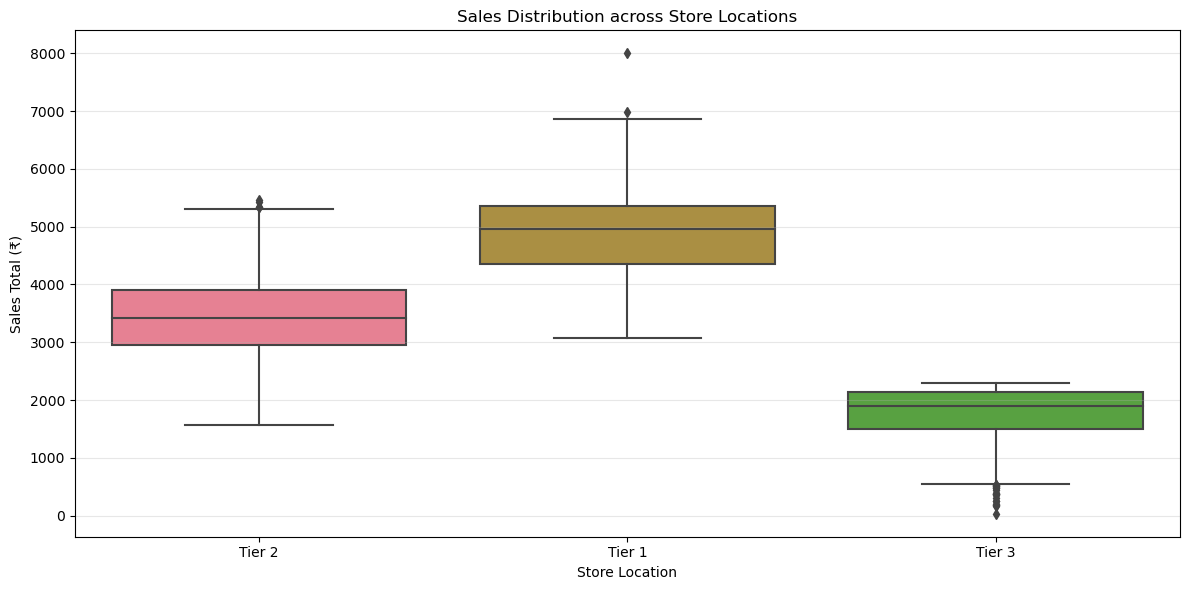

In [74]:
# Box Plot
sns.boxplot(data=df, x='Store_Location_City_Type', y='Product_Store_Sales_Total')
plt.title('Sales Distribution across Store Locations')
plt.xlabel('Store Location')
plt.ylabel('Sales Total (₹)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

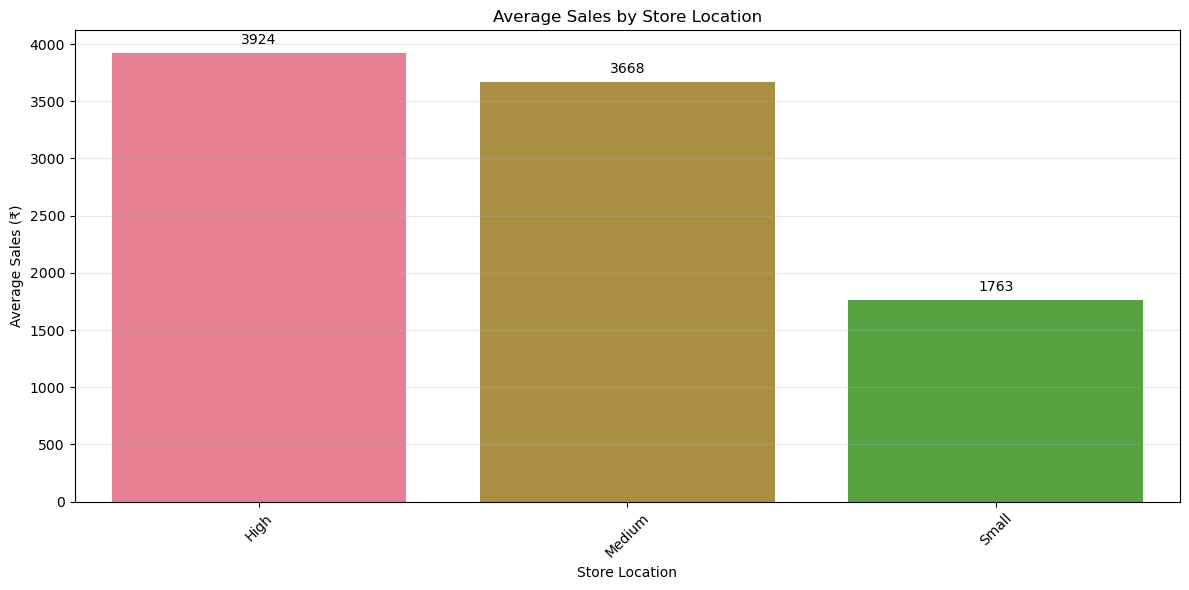

In [75]:
# Order by logical tier progression
tier_order = ['Tier 1', 'Tier 2', 'Tier 3']
tier_sales = df.groupby('Store_Location_City_Type')['Product_Store_Sales_Total'].mean().reindex(tier_order)

sns.barplot(x=avg_sales.index, y=avg_sales.values)
plt.xticks(rotation=45)
plt.title('Average Sales by Store Location')
plt.xlabel('Store Location')
plt.ylabel('Average Sales (₹)')

# Add value labels
for index, value in enumerate(avg_sales.values):
    plt.text(index, value + 50, f'{value:.0f}', ha='center', va='bottom')

plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [76]:
avg_sales

Store_Size
High      3923.778802
Medium    3668.222573
Small     1762.942465
Name: Product_Store_Sales_Total, dtype: float64

In [77]:
# Get tier cities frequencies in pct
tier_cities_freq = df['Store_Location_City_Type'].value_counts(normalize=True)
tier_cities_freq

Store_Location_City_Type
Tier 2    0.714595
Tier 1    0.153943
Tier 3    0.131462
Name: proportion, dtype: float64

⚡ **Insights**

- **Clear tier hierarchy**: Tier 1 cities deliver 43% higher sales than Tier 2 (₹4,947 vs ₹3,457), confirming economic tier advantages
  
- **Quality over quantity**: 🧐 **_Despite Tier 2 cities having 71% of SuperKart's locations, Tier 1 stores significantly outperform_** - showing fewer premium locations beat many average ones. 
  
- **Significant market gaps**: 2.8x performance difference between Tier 1 and Tier 3 cities indicates distinct market dynamics rather than gradual scaling

- **Strategic insight**: Tier 1 focus could maximize revenue, while Tier 3 performance matches Small stores suggesting similar constraints

**MultiVariate Analysis**

#### 6. Product Type, Store Size & Sales

- helps identify which product types sell better in which store sizes.

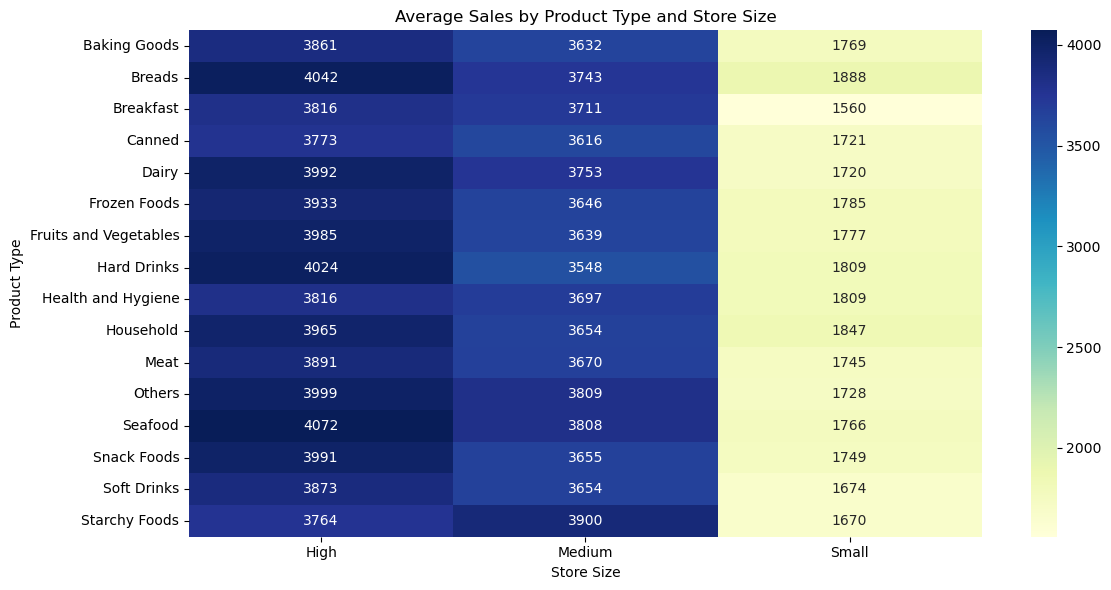

In [78]:
# Pivot table: Average sales for each (Product_Type, Store_Size) combination
pivot = df.pivot_table(index='Product_Type',
                       columns='Store_Size',
                       values='Product_Store_Sales_Total',
                       aggfunc='mean')

sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Average Sales by Product Type and Store Size")
plt.xlabel("Store Size")
plt.ylabel("Product Type")
plt.tight_layout()
plt.show()

In [79]:
pivot

Store_Size,High,Medium,Small
Product_Type,,,
Baking Goods,3861.257647,3632.219959,1769.380208
Breads,4042.469667,3743.188299,1887.803043
Breakfast,3816.110000,3710.780370,1559.740000
Canned,3773.246891,3616.167383,1721.223409
Dairy,3991.784133,3753.251365,1720.078654
Frozen Foods,3933.498662,3646.352236,1785.108416
Fruits and Vegetables,3984.887387,3638.704218,1776.806905
Hard Drinks,4024.230000,3547.559576,1809.395000
Health and Hygiene,3815.836053,3697.496667,1809.459451


In [80]:
avg_sales

Store_Size
High      3923.778802
Medium    3668.222573
Small     1762.942465
Name: Product_Store_Sales_Total, dtype: float64

⚡ **Insights**

- Larger Stores Drive Higher Sales Across All Product Types
- Starchy Foods Stand Out in Medium Stores
- Breakfast saws steep drop in average sales in 'Small Stores', suggesting these may be space-sensitive or impulse-driven products more effectively sold in larger formats.

#### 7. Product Type, Store Type & Sales

- Which products thrive in which store formats


In [81]:
# Pivot table for average sales per Product_Type and Store_Type
pivot = df.pivot_table(
    index='Product_Type',
    columns='Store_Type',
    values='Product_Store_Sales_Total',
    aggfunc='mean'
)

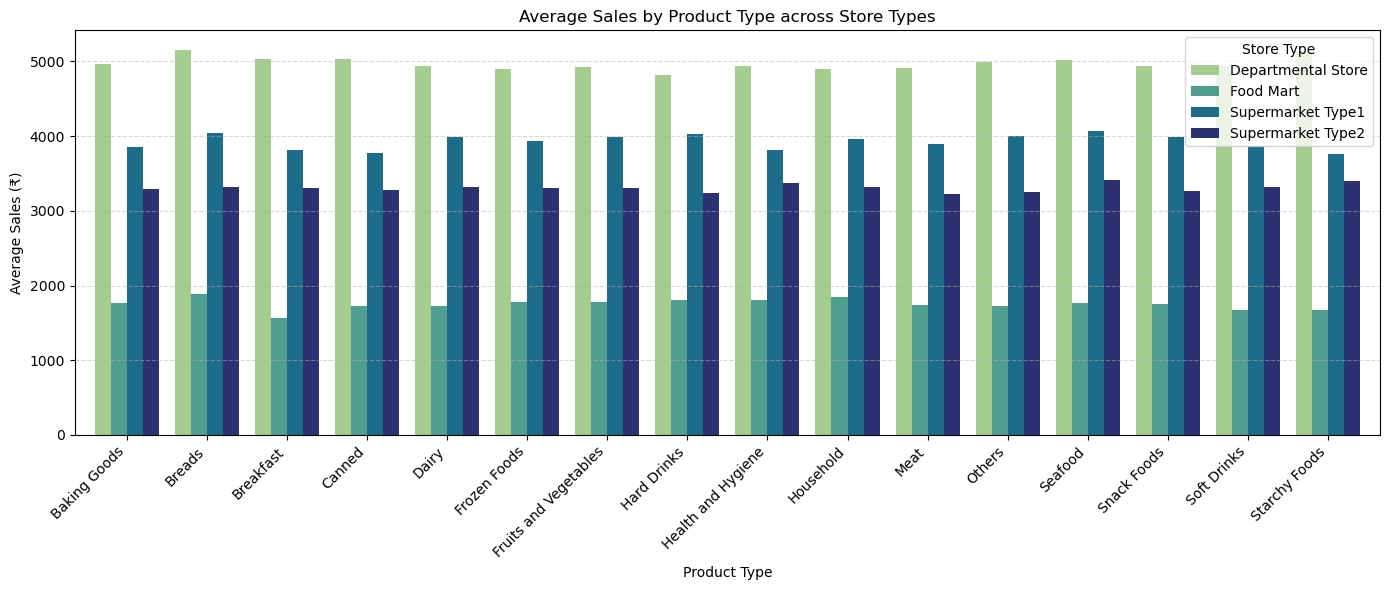

In [82]:
# Plot: Grouped bar
pivot.plot(kind='bar', figsize=(14, 6), width=0.8, colormap='crest')

plt.title('Average Sales by Product Type across Store Types')
plt.ylabel('Average Sales (₹)')
plt.xlabel('Product Type')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Store Type')
plt.tight_layout()
plt.show()

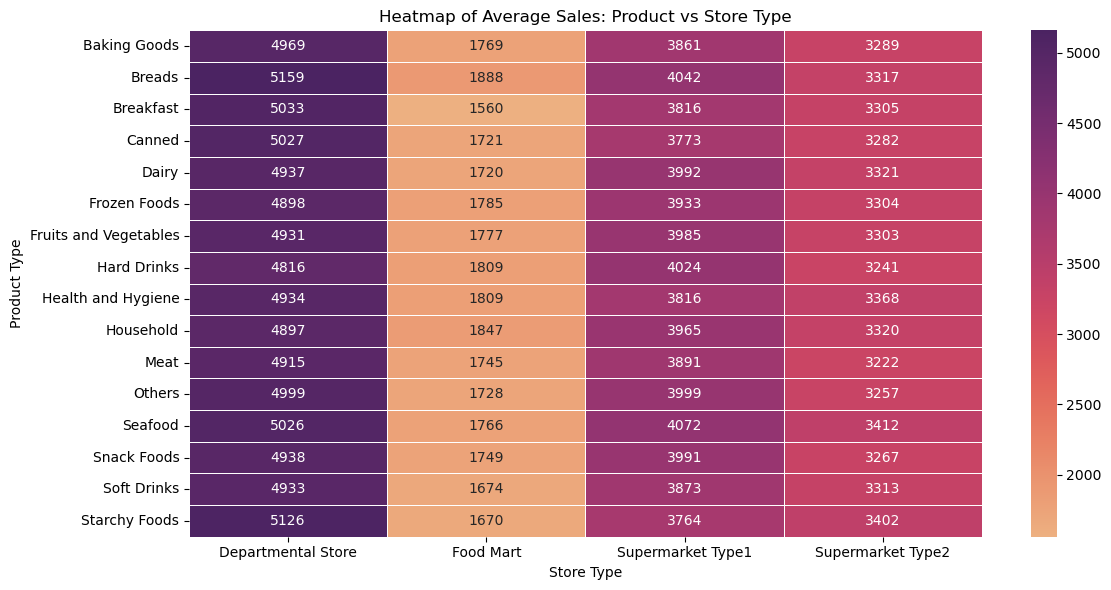

In [83]:
# Same pivot as above
sns.heatmap(pivot, annot=True, fmt=".0f", cmap='flare', linewidths=0.5)

plt.title('Heatmap of Average Sales: Product vs Store Type')
plt.xlabel('Store Type')
plt.ylabel('Product Type')
plt.tight_layout()
plt.show()

In [84]:
# Summary statistics
print("Top 3 combinations by sales:")
combinations = df.groupby(['Product_Type', 'Store_Type'])['Product_Store_Sales_Total'].mean().sort_values(ascending=False)
print(combinations.head(3).round(0))

Top 3 combinations by sales:
Product_Type   Store_Type        
Breads         Departmental Store    5159.0
Starchy Foods  Departmental Store    5126.0
Breakfast      Departmental Store    5033.0
Name: Product_Store_Sales_Total, dtype: float64


In [85]:
pivot

Store_Type,Departmental Store,Food Mart,Supermarket Type1,Supermarket Type2
Product_Type,,,,
Baking Goods,4968.769697,1769.380208,3861.257647,3288.535740
Breads,5158.586176,1887.803043,4042.469667,3317.316372
Breakfast,5033.372632,1559.740000,3816.110000,3305.469839
Canned,5027.168556,1721.223409,3773.246891,3281.982895
Dairy,4936.654759,1720.078654,3991.784133,3321.025945
Frozen Foods,4898.429672,1785.108416,3933.498662,3303.855717
Fruits and Vegetables,4930.975055,1776.806905,3984.887387,3302.713800
Hard Drinks,4815.665217,1809.395000,4024.230000,3240.544526
Health and Hygiene,4934.148090,1809.459451,3815.836053,3367.969790


⚡ **Insights**

- **Departmental Store dominance**: Departmental Stores dominate sales across all product types, indicating stronger customer engagement or product availability.
  
- **Staple foods excel in premium formats**: Breads, Starchy Foods, and Breakfast items perform exceptionally well in Departmental Stores — likely driven by routine or impulse buys, shows essential items thrive in full-service environments

- **Food Mart underperformance**: Food Marts lag behind in sales for most categories, suggesting possible limitations in reach, assortment, or store scale.

- **Strategic insight**: Expanding Departmental Store format could boost performance across entire product portfolio rather than optimizing specific product-store matches

- **Format-agnostic performance**: Similar relative product rankings across store types suggest product characteristics matter more than format-specific synergies

---

## Preprocessing

---

### REMEMBER 🧠

**🎯 Decision Flow**

1. Data Type? → Numeric: Scale → Categorical: Encode
2. Missing Values? → Impute
3. Outliers? → Handle (remove/clip/robust methods)
4. Feature Count? → High: Select → Low: Keep all
5. Interpretability? → High: Linear/Ridge → Low: Any regularization
6. Overfitting? → Yes: Increase regularization → No: Decrease
7. Performance? → Good: Done → Poor: Feature engineering

**🔗 Pipeline Order**

1. Handle missing values (imputation)
2. Transform (log, box-cox, etc.)  
3. Scale (StandardScaler, etc.)
4. Feature selection (if needed)

**Transformation vs Scaling - Key Distinction:** 

**Transformation** = Changes **distribution shape**
- Log transform (for skewed data)
- Square root, polynomial transforms
- **Purpose**: Fix skewness, non-linearity
  
**Scaling** = Changes **range/magnitude** but preserves shape
- StandardScaler, MinMaxScaler, RobustScaler
- **Purpose**: Put features on similar scales

**Simple Example:**

Product_Weight: [8, 12, 16] kg

Product_MRP: [100, 150, 200] rupees

**Without scaling**: Linear regression might favor MRP (larger numbers)

**With scaling**: Both features get equal importance consideration

#### Linear Regression: Transformation vs Scaling - Rule of Thumb



- **Transformation** = Changes distribution shape (log, sqrt) → Fix skewness/non-linearity
- **Scaling** = Changes magnitude, preserves shape → Put features on equal footing

**Scaling in Linear Regression**
**Why Almost Always Needed:**
- **Undue advantage problem**: Large-scale features (e.g., area=2000) dominate small-scale features (e.g., rooms=3)
- **Algorithm bias**: Loss function responds more to large-magnitude changes
- **Coefficient quality**: Large-scale features get "granular optimization", small-scale features get "lazy optimization"

**Gradient Descent Behavior:**
- Large-scale feature coefficients → Get refined through many iterations ✅
- Small-scale feature coefficients → Barely updated, stuck at suboptimal values ❌

**When to Scale/Transform**
- **Basic OLS**: Scaling recommended (coefficient interpretability)
- **Regularized LR**: Scaling mandatory (Ridge/Lasso penalties)
- **Transformation**: Statistical decision based on distribution analysis

**Memory Hook**
*"Features with larger raw values get artificial loudness in the loss function - scaling makes everyone speak at the same volume."*

#### Imbalance for Regression

📌 NOTE:

**Classification algorithms**:
- Can get biased toward majority class
- Need sampling techniques (SMOTE, etc.)

**Linear Regression**:
- Learns coefficients based on available data
- No inherent bias toward frequent categories

**In addition** 👀

- **"Imbalance treatment"** (like resampling or class weighting) is typically required for **target variable** imbalance in classification tasks — not for feature columns.

- For **categorical feature columns**, it's natural for some categories to dominate. That's simply part of the data distribution.

#### Encoding & High Cardinality

📌 Point in Question:

“Due to high cardinality, encoding options like target encoding or learned embeddings may be more effective than simple one-hot encoding.”

Generally

- ✅ **One-Hot Encoding (OHE)** → Preferred for **Linear Models** (like Linear Regression), since they assume linearity and independence between features.

- **✅ Target Encoding** → Works well with **Tree-based models** (like Random Forest, XGBoost), since they can handle ordinal relationships and benefit from the signal in the target.

> 💡 OHE can hurt tree models by increasing dimensionality unnecessarily, while target encoding may leak info in linear models.

---

### NOTE: Use below cell if want detail report for all columns

In [86]:
# from ydata_profiling import ProfileReport

# # Quick outlier summary
# profile = ProfileReport(df, title="Outlier & Data Profile", explorative=True)
# profile.to_notebook_iframe()  # or profile.to_file("report.html")

### Outlier Detection

🤔 Why IQR over Z-score:
- More robust: Works with skewed data (like our Product_Allocated_Area)
- No distribution assumptions: Doesn't require normal distribution
- Industry standard: More commonly used in practice

In [87]:
def detect_outliers_iqr(df):
    """
    Detect outliers using IQR method (consistent with our EDA approach)
    """
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

    outlier_summary = []

    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_count = len(outliers)
        outlier_percentage = (outlier_count / len(df)) * 100

        outlier_summary.append({
            'Column': col,
            'Outlier_Count': outlier_count,
            'Outlier_Percentage': round(outlier_percentage, 2)
        })

    return pd.DataFrame(outlier_summary)

In [88]:
# Quick outlier check
outlier_results = detect_outliers_iqr(df)
print(outlier_results)

                      Column  Outlier_Count  Outlier_Percentage
0             Product_Weight             54                0.62
1     Product_Allocated_Area            104                1.19
2                Product_MRP             57                0.65
3   Store_Establishment_Year              0                0.00
4  Product_Store_Sales_Total            119                1.36


> 📌 Rule of thumb: If outliers < 5% of data, skewness between -1 and 1, and reasonable scale → no target preprocessing needed!

🔍 **Observations**

- 1% is typically acceptable:
- Most real-world datasets have 1-5% outliers
- IQR method can be conservative (finds more outliers than Z-score)
- 1% suggests data quality is quite good

**📊Key Observations:**

- **Minimal outlier presence**: All features show <1.5% outliers, indicating high data quality across SuperKart's dataset

- **Target variable outliers**: 119 outliers (1.36%) in sales data likely represent legitimate high-performing product-store combinations, not data errors

- **Store_Establishment_Year clean**: Zero outliers confirm only 4 establishment years with consistent data entry

- **Treatment recommendation**: Keep outliers as they represent valid business scenarios (premium products, exceptional performance) rather than data quality issues

- **Preprocessing decision**: No outlier treatment needed - low percentages suggest authentic extreme values rather than measurement errors

No outlier treatment is needed for the **target variable** (`Product_Store_Sales_Total`) because:

- 📉 **Altering target values can distort the true signal** your model is trying to learn.
- 🧠 Models, especially **tree-based ones (like CatBoost)**, are **robust** to such minor outliers.
- 📊 The percentage of outliers is **very low (\~1.36%)**, indicating **minimal risk** of skewing model performance.

### 🔧 Preprocessing Plan of Action

We will build and evaluate **two models**:

1. **Linear Model** – which requires numerical stability and feature scaling.
2. **Tree-Based Model (CatBoost)** – which handles categorical features natively and is robust to scaling.

In this phase, we will:

* Identify and define appropriate **preprocessing steps** for each model type.
* Implement any necessary **custom transformers** (e.g., feature engineering).
* Construct a preprocessing pipeline using `ColumnTransformer`.

The **final model pipelines** (preprocessing + estimator) will be built during the modeling phase.


**🧠 REMEMBER**

🔁 Typical pipeline order:

1. Impute missing values
2. Encode categorical features
3. Transform (e.g., log, binning, etc.)
4. Scale numerical features
5. Model

- All feature transformations (like encoding, imputation, log transforms, etc.) are ideally done before scaling.

**Logical rationale:**
1. **Missing values first** - Need complete data before other operations
2. **Encode categoricals** - Convert to numeric format
3. **Transform** - Change distributions (log, etc.) on original scale
4. **Scale** - Standardize the final transformed features
5. **Model** - Use processed data

**Key insight:** Transform before scaling because you want to scale the final transformed distribution, not transform already-scaled values.

Also for Target Column: 
- showed good properties in EDA - near-normal distribution (mean ≈ median)
- Transform target only if residual analysis (linear model case) show problems (check later)

### Prep - Steps Setup (Preprocessing)

**Interpretation Guideline (general - numeric)** 🚀

| Question            | Indicator                                                           |
| ------------------- | ------------------------------------------------------------------- |
| **Scaling needed?** | For numeric with large range or skew - Yes                          |
| **Log transform?**  | If skew > 1 or < -1                                                 |
| **Outliers?**       | If outliers > 2–5%                                                  |
| **Encoding?**       | Categorical with low cardinality → OneHot; ordinal → OrdinalEncoder |




1. **Is it skewed?** (|skew| > 1)
   - **YES** → Transform first (log, box-cox)
   - **NO** → No transform needed

2. **Are there outliers?** (>5% extreme values)
   - **YES** → Use RobustScaler  
   - **NO** → Use StandardScaler

**🧠 REMEMBER**

**Encoded Categorical Features:**
- **Don't treat as true numericals** - they're enumerated values
- **Skip outlier/skewness checks** for one-hot encoding (0/1 values)
- **Maybe light preprocessing** for ordinal/target encoding, but not full numerical treatment

**True Numerical Features:**
- **Full preprocessing needed** - outliers, skewness, scaling, transformations
- **These actually represent continuous quantities**

## **Rule of Thumb:**
```
One-hot encoded → Leave alone (just 0s and 1s)
Ordinal encoded → Maybe scale, but don't overthink it  
Target encoded → Treat more like numerical
True numerical → Full preprocessing pipeline
```

**Key insight**: Don't lose sight of the **original data nature** just because encoding made it numeric!

#### Helper Snippets

In [89]:
def summarize_numeric_column(df, col):
    series = df[col].dropna()
    skewness = skew(series)
    outliers = (abs(zscore(series)) > 3).sum()
    outlier_pct = (outliers / len(series)) * 100

    print(f"\n📈 Column: {col}")
    print(f"Skewness: {skewness:.2f}")
    print(f"Outlier Count (Z > 3): {outliers} ({outlier_pct:.2f}%)")
    print(f"Min: {series.min()}, Max: {series.max()}")
    print(f"Mean: {series.mean():.2f}, Std: {series.std():.2f}")

In [93]:
def summarize_categorical_column(df, col):
    counts = df[col].value_counts()
    percentages = df[col].value_counts(normalize=True) * 100
    summary = pd.DataFrame({
        'Count': counts,
        'Percentage (%)': percentages.round(2)
    })
    imbalance_ratio = counts.max() / counts.min() if counts.min() > 0 else float('inf')

    print(f"\n🪪 Column: {col}")
    print(f"Unique Categories: {df[col].nunique()}")
    print(f"Imbalance Ratio (max/min): {imbalance_ratio:.2f}")
    print(summary)

**Interpretation Guideline**

| Metric                  | When to Act                                                                       |
| ----------------------- | --------------------------------------------------------------------------------- |
| Skewness > ±1           | Consider log or power transformation                                              |
| Outlier % > 2–5%        | Consider treatment (cap, impute, remove)                                          |
| Imbalance Ratio > 4     | May affect encoding; be cautious                                                  |
| Unique Categories = 2–5 | OneHot/Ordinal (case-by-case)                                                     |
| Unique Categories > 10  | High cardinality — use frequency/target encoding if needed (for tree models only) |


**💡 Z-Score Interpretation**

- Any data point with |Z| > 3 is in the extreme 0.3%, i.e., very far from the mean.
- Hence, such points are considered statistical outliers.

NOTE: 

As a general guideline:

* ✅ **|Skewness| ≤ 0.5** → Data is fairly symmetric → **Z-score is reliable**
* ⚠️ **0.5 < |Skewness| < 1** → Moderate skew → Z-score **can be used with caution**
* ❌ **|Skewness| ≥ 1** → Highly skewed → **Avoid Z-score**, prefer **IQR method**

So, **Z-score is best used when skewness is close to 0** (i.e., data is approximately normal).

> Z-Score assumes a normal distribution. For skewed data, use the IQR method instead.

#### Custom Data Cleaner (For Task)

**CustomDataCleaner** will include:
- Product_Sugar_Content: 'reg' → 'Regular'
- Any other data quality issues we identify
- Future cleaning rules as needed

In [106]:
class CustomDataCleaner(BaseEstimator, TransformerMixin):
    """
    Custom transformer to handle data quality issues across all columns
    For now
    - Product_Sugar_Content: 'reg' → 'Regular'
    """

    def __init__(self):
        """Initialize the data cleaner"""
        # Define rare categories to merge into 'Others'
        self.rare_categories_to_merge = [
            'Breads', 'Hard Drinks', 'Starchy Foods',
            'Breakfast', 'Seafood'
        ]
        pass

    def fit(self, X, y=None):
        """
        Fit method (required for sklearn compatibility)
        No fitting needed for data cleaning operations
        """
        return self

    def transform(self, X):
        """
        Apply data cleaning transformations

        Args:
            X: DataFrame to clean

        Returns:
            DataFrame with cleaned data
        """
        # Create a copy to avoid modifying original data
        X_cleaned = X.copy()

        # 1. Fix Product_Sugar_Content inconsistency (reg → Regular)
        if 'Product_Sugar_Content' in X_cleaned.columns:
            X_cleaned['Product_Sugar_Content'] = X_cleaned['Product_Sugar_Content'].replace(
                'reg', 'Regular'
            )

        # 2. Group rare Product_Type categories into 'Others'
        if 'Product_Type' in X_cleaned.columns:
            X_cleaned['Product_Type'] = X_cleaned['Product_Type'].replace(
                self.rare_categories_to_merge, 'Others'
            )

        # Add other data cleaning rules here as needed
        # Example: Fix whitespace, case issues, etc.

        return X_cleaned

    def get_feature_names_out(self, input_features=None):
        """
        Return feature names for output features
        Required for sklearn compatibility
        """
        return input_features

In [108]:
# Test the CustomDataCleaner
def test_custom_data_cleaner():
    # Create sample data with both issues
    test_data = pd.DataFrame({
        'Product_Sugar_Content': ['Regular', 'reg', 'Low Sugar', 'No Sugar', 'reg', 'Low Sugar'],
        'Product_Type': ['Dairy', 'Breads', 'Snack Foods', 'Seafood', 'Others', 'Breakfast'],
        'Other_Col': [1, 2, 3, 4, 5, 6]
    })

    # Test the transformer
    cleaner = CustomDataCleaner()
    cleaner.fit(test_data)  # No-op but required
    cleaned_data = cleaner.transform(test_data)

    # Check Product_Sugar_Content results
    print("=== Product_Sugar_Content Cleaning ===")
    print("Before:")
    print(test_data['Product_Sugar_Content'].value_counts())
    print("\nAfter:")
    print(cleaned_data['Product_Sugar_Content'].value_counts())

    # Check Product_Type grouping results
    print("\n=== Product_Type Grouping ===")
    print("Before:")
    print(test_data['Product_Type'].value_counts())
    print("\nAfter:")
    print(cleaned_data['Product_Type'].value_counts())

test_custom_data_cleaner()

=== Product_Sugar_Content Cleaning ===
Before:
Product_Sugar_Content
reg          2
Low Sugar    2
Regular      1
No Sugar     1
Name: count, dtype: int64

After:
Product_Sugar_Content
Regular      3
Low Sugar    2
No Sugar     1
Name: count, dtype: int64

=== Product_Type Grouping ===
Before:
Product_Type
Dairy          1
Breads         1
Snack Foods    1
Seafood        1
Others         1
Breakfast      1
Name: count, dtype: int64

After:
Product_Type
Others         4
Dairy          1
Snack Foods    1
Name: count, dtype: int64


#### Evaluating Columns For Custom Transformer

In [91]:
summarize_numeric_column(df, 'Product_Weight')


📈 Column: Product_Weight
Skewness: 0.02
Outlier Count (Z > 3): 24 (0.27%)
Min: 4.0, Max: 22.0
Mean: 12.65, Std: 2.22


In [94]:
summarize_categorical_column(df, 'Product_Sugar_Content')


🪪 Column: Product_Sugar_Content
Unique Categories: 4
Imbalance Ratio (max/min): 45.23
                       Count  Percentage (%)
Product_Sugar_Content                       
Low Sugar               4885           55.75
Regular                 2251           25.69
No Sugar                1519           17.33
reg                      108            1.23


- Low Cardinality
- No need any imbalance treatment (its natural seemingly)
- However, `reg` is most likely a mislabel of `Regular`, So we need to treat it correctly

In [101]:
summarize_numeric_column(df, 'Product_Allocated_Area')


📈 Column: Product_Allocated_Area
Skewness: 1.13
Outlier Count (Z > 3): 75 (0.86%)
Min: 0.004, Max: 0.298
Mean: 0.07, Std: 0.05


- mild outliers (~1.2%) — no treatment required
- Actions
  - Apply Power Transformation to reduce skew

> PowerTransformer already standardizes the data by default, Hence Scaling also not needed for this !

In [102]:
summarize_categorical_column(df, 'Product_Type')


🪪 Column: Product_Type
Unique Categories: 16
Imbalance Ratio (max/min): 16.43
                       Count  Percentage (%)
Product_Type                                
Fruits and Vegetables   1249           14.25
Snack Foods             1149           13.11
Frozen Foods             811            9.25
Dairy                    796            9.08
Household                740            8.44
Baking Goods             716            8.17
Canned                   677            7.73
Health and Hygiene       628            7.17
Meat                     618            7.05
Soft Drinks              519            5.92
Breads                   200            2.28
Hard Drinks              186            2.12
Others                   151            1.72
Starchy Foods            141            1.61
Breakfast                106            1.21
Seafood                   76            0.87


In [105]:
df.groupby("Product_Type")["Product_Store_Sales_Total"].mean()

Product_Type
Baking Goods             3425.958101
Breads                   3574.711200
Breakfast                3416.324623
Canned                   3397.463383
Dairy                    3532.560352
Frozen Foods             3464.834562
Fruits and Vegetables    3443.421353
Hard Drinks              3364.594731
Health and Hygiene       3445.393646
Household                3465.865095
Meat                     3445.326764
Others                   3586.068212
Seafood                  3584.263684
Snack Foods              3471.711880
Soft Drinks              3462.513911
Starchy Foods            3679.251418
Name: Product_Store_Sales_Total, dtype: float64

**Observation 👀**

- Minimum avg sales: ~3364 (Hard Drinks)
- Maximum avg sales: ~3679 (Starchy Foods)
- Overall range: ≈ 315
- This is less than 10% variance in average sales between most categories, which means:
- ✅ **Sales performance is fairly uniform across product types**
  - Standalone predictive power: Almost zero 
  - Feature Interactions (main reason) - might help in prediction

**Reckoning and Insights 🧐**

- Some rare categories (Starchy Foods: 3679, Seafood: 3584) are TOP performers
- Narrow range: Only 9% difference between best/worst (3679 vs 3365)
- Bottom 6 categories have <200 samples each

**Grouping Challanges**:

- Can't group by sample size alone: Would lose high-performing signals (Starchy Foods, Seafood)


🥇 **Most Viable: Mapping to Others**

- Hence let rare types { Breads, Hard Drinks, Starchy Foods, BreakFast, Seafood } be clubbed into others
-  Simple and robust
-  Keep dimensionality lower
-  

However For More Nuance we can try below as well (ie introduce 2 new groups):

- **Rare_High_Sales**: Seafood, Starchy Foods, Breads
- **Rare_Low_Sales**: Hard Drinks, Breakfast

---

### REMEMBER

Pipeline Facade Structures (general idea)

```
Pipeline(steps=[
    ('preprocessor', ColumnTransformer([
        # Encoding / scaling per column group
    ])),
    ('model', LinearRegression or Ridge or ... )
])
```

```
Pipeline(steps=[
    ('feature_engineering', CustomTransformer()),  # optional
    ('preprocessing', ColumnTransformer([...]),    # encoding + scaling
    ('feature_selection', SelectKBest(...)),       # optional
    ('model', Ridge())                             # or CatBoost, etc.
])
```


```
Pipeline([
    ('preprocessing', ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])),
    ('model', LinearRegression())
])
```

For Tree based models
```
Pipeline([
    ('model', CatBoostRegressor(...))
])
```
